# Capstone Final Notebook
## 1. Import Libraries

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6b7935c037bacd3b65e887fd0d03785c7524427d4bf8aaff822afc5394cb93f3
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.9 MB/s eta 0:00:00


In [ ]:
# Data Handling and Numerical Operations
import pandas as pd
import numpy as np
from typing import Union, List, Dict
import sys

# Financial Data and Technical Indicators
import yfinance as yf
import ta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Optimization
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# Performance Metrics and Utilities
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
import logging
import time
from joblib import Parallel, delayed  # For parallel processing

# Suppress warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Set Configuration Parameters

In [ ]:
# Configuration dictionary for flexibility across markets
CONFIG = {
    'markets': ['EURUSD=X'],
    'start_date': '2014-01-01',
    'end_date': '2024-01-01',
    'short_window': 50,
    'long_window': 200,
    'lookback': 20,
    'entry_threshold': 1.5,
    'exit_threshold': 0.5,
    'max_position': 1,
    'stop_loss': 0.02,
    'atr_period': 14,
    'autoencoder_epochs': 50,
    'autoencoder_batch_size': 32,
    'encoding_dim': 4,
    'model_epochs': 20,
    'model_batch_size': 32,
    'test_window_size': 50,
}

## 3. Define Utility Functions

In [ ]:
def calculate_atr(df: pd.DataFrame, period: int) -> pd.Series:
    """
    Calculate the Average True Range (ATR) for dynamic risk management.

    Args:
        df: DataFrame with 'High', 'Low', 'Close' columns.
        period: Lookback period for ATR calculation.

    Returns:
        pd.Series: ATR values.
    """
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(window=period).mean()

def sortino_ratio(returns: pd.Series, target: float = 0, annual_factor: int = 252) -> float:
    """
    Calculate the Sortino Ratio (downside risk-adjusted return).

    Args:
        returns: Series of strategy returns.
        target: Target return (default 0).
        annual_factor: Annualization factor (default 252 trading days).

    Returns:
        float: Sortino Ratio.
    """
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt(np.mean(downside_returns**2)) * np.sqrt(annual_factor) if not downside_returns.empty else 0
    annualized_return = returns.mean() * annual_factor
    return annualized_return / downside_deviation if downside_deviation != 0 else 0

def calmar_ratio(cumulative_returns: pd.Series, annual_factor: int = 252) -> float:
    """
    Calculate the Calmar Ratio (return over max drawdown).

    Args:
        cumulative_returns: Series of cumulative returns.
        annual_factor: Annualization factor (default 252 trading days).

    Returns:
        float: Calmar Ratio.
    """
    annualized_return = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0]) ** (annual_factor / len(cumulative_returns)) - 1
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / rolling_max - 1)
    max_drawdown = abs(drawdown.min())
    return annualized_return / max_drawdown if max_drawdown != 0 else 0

## 4. Fetch Market Data

In [ ]:
def get_market_data(tickers: List[str], start_date: str, end_date: str) -> Dict[str, pd.DataFrame]:
    """
    Download and process market data for specified tickers.

    Args:
        tickers: List of ticker symbols.
        start_date: Data start date (YYYY-MM-DD).
        end_date: Data end date (YYYY-MM-DD).

    Returns:
        Dictionary mapping ticker symbols to cleaned DataFrames.
    """
    if pd.to_datetime(start_date) >= pd.to_datetime(end_date):
        raise ValueError("start_date must be earlier than end_date")

    data_dict = {}
    for ticker in tickers:
        logging.info(f"Downloading data for {ticker}...")
        attempts = 0
        success = False
        is_forex = '=' in ticker
        max_attempts = 5

        while attempts < max_attempts and not success:
            try:
                data = yf.download(ticker, start=start_date, end=end_date, progress=False, ignore_tz=True)
                if data.empty:
                    logging.warning(f"No data found for {ticker}.")
                    break

                if isinstance(data.columns, pd.MultiIndex):
                    data.columns = [col[0] for col in data.columns]

                pair_data = data.reset_index().rename(columns={'index': 'Date'})
                pair_data['Date'] = pd.to_datetime(pair_data['Date'])

                required_cols = ['Open', 'High', 'Low', 'Close']
                available_cols = pair_data.columns.tolist()
                missing_cols = [col for col in required_cols if col not in available_cols]
                if missing_cols:
                    logging.warning(f"{ticker} missing columns {missing_cols}. Attempting fallback...")
                if 'Close' not in pair_data.columns and 'Adj Close' in pair_data.columns:
                    pair_data['Close'] = pair_data['Adj Close']
                    required_cols.remove('Close')

                pair_data[required_cols] = pair_data[required_cols].fillna(method='ffill')
                pair_data = pair_data.dropna(subset=['Close'])

                pair_data['Volume'] = 0 if (is_forex or 'Volume' not in pair_data.columns) else pair_data['Volume'].fillna(0)

                final_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
                pair_data = pair_data[final_cols]

                logging.info(f"{ticker} - Data points: {len(pair_data)} | NaNs remaining: {pair_data.isna().sum().sum()}")
                print(f"\nCleaned data sample for {ticker}:")
                print(pair_data.head())

                data_dict[ticker] = pair_data
                success = True

            except Exception as e:
                logging.error(f"Error fetching/processing {ticker}: {e}")
                attempts += 1
                time.sleep(2 ** attempts)
                if attempts == max_attempts:
                    logging.error(f"Failed to process {ticker} after {attempts} attempts.")

    return data_dict

# Fetch data
data_dict = get_market_data(CONFIG['markets'], CONFIG['start_date'], CONFIG['end_date'])


Cleaned data sample for EURUSD=X:
        Date      Open      High       Low     Close  Volume
0 2014-01-01  1.374495  1.377904  1.374400  1.374495       0
1 2014-01-02  1.376595  1.377467  1.363271  1.376671       0
2 2014-01-03  1.366624  1.367297  1.360170  1.366662       0
3 2014-01-06  1.359582  1.364610  1.357279  1.359601       0
4 2014-01-07  1.363066  1.365799  1.359878  1.363196       0


## 5. Preprocessing and Feature Engineering

In [ ]:
def create_moving_average_spread(df: pd.DataFrame, short_window: int, long_window: int, price_col: str = 'Close') -> pd.DataFrame:
    """
    Create moving averages and synthetic spread.

    Args:
        df: Input DataFrame with price data.
        short_window: Short-term MA window.
        long_window: Long-term MA window.
        price_col: Column name for price data.

    Returns:
        pd.DataFrame: DataFrame with MA and spread columns.
    """
    try:
        df = df.copy()
        df['MA_Short'] = df[price_col].rolling(window=short_window).mean()
        df['MA_Long'] = df[price_col].rolling(window=long_window).mean()
        df['Synthetic_Spread'] = df[price_col] - df['MA_Short']
        df['MA_Spread'] = df['MA_Short'] - df['MA_Long']
        df = df.dropna()
        logging.info(f"Data after spread creation: {len(df)} rows")
        return df
    except Exception as e:
        logging.error(f"Error during spread creation: {e}")
        return pd.DataFrame()

def feature_engineering(df: pd.DataFrame, price_col: str = 'Close') -> pd.DataFrame:
    """
    Add technical indicators as features.

    Args:
        df: Input DataFrame with price data.
        price_col: Column name for price data.

    Returns:
        pd.DataFrame: DataFrame with additional features.
    """
    try:
        df = df.copy()
        df['Log_Returns'] = np.log(df[price_col] / df[price_col].shift(1))
        df['RSI'] = ta.momentum.RSIIndicator(df[price_col], window=14).rsi()
        macd = ta.trend.MACD(df[price_col])
        df['MACD'] = macd.macd()
        bb = ta.volatility.BollingerBands(df[price_col])
        df['Bollinger_Upper'] = bb.bollinger_hband()
        df['Bollinger_Lower'] = bb.bollinger_lband()
        df['MA_Cross'] = (df['MA_Short'] > df['MA_Long']).astype(int)
        df['Volatility'] = df['Log_Returns'].rolling(window=20).std()
        df = df.dropna()
        logging.info(f"Data after feature engineering: {len(df)} rows")
        return df
    except Exception as e:
        logging.error(f"Error during feature engineering: {e}")
        return pd.DataFrame()

# Apply preprocessing
for ticker, data in data_dict.items():
    data = create_moving_average_spread(data, CONFIG['short_window'], CONFIG['long_window'], price_col='Close')
    data = feature_engineering(data, price_col='Close')
    data_dict[ticker] = data

# Assign processed data to a variable for later use
data = data_dict[CONFIG['markets'][0]]

# Metrics after preprocessing
print(f"Metrics after preprocessing - Rows: {len(data)}, NaN count: {data.isna().sum().sum()}")
print(f"Sample feature stats:\n{data[['Log_Returns', 'RSI', 'MACD', 'Volatility']].describe()}")


Metrics after preprocessing - Rows: 2381, NaN count: 0
Sample feature stats:
       Log_Returns          RSI         MACD   Volatility
count  2381.000000  2381.000000  2381.000000  2381.000000
mean     -0.000050    49.062652    -0.000522     0.004833
std       0.005100    11.303718     0.005979     0.001705
min      -0.028144    16.508668    -0.023900     0.001770
25%      -0.003016    41.271144    -0.004184     0.003731
50%      -0.000047    48.649255    -0.000731     0.004478
75%       0.002879    56.788663     0.003235     0.005602
max       0.028145    81.588468     0.014898     0.011325


## 6. LSTM-based Autoencoder with Hyperparameter Tuning

In [ ]:
def create_autoencoder(input_shape, lstm_units, encoding_dim):
    """Create an LSTM autoencoder model."""
    # Encoder
    inputs = Input(shape=input_shape)
    encoded = LSTM(lstm_units, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(int(lstm_units / 2), activation='relu')(encoded)
    encoded = RepeatVector(input_shape[0])(encoded)  # Repeat to match original sequence length

    # Decoder
    decoded = LSTM(int(lstm_units / 2), activation='relu', return_sequences=True)(encoded)
    decoded = LSTM(lstm_units, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[-1]))(decoded)  # Output layer to match feature dimension

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

def objective(trial):
    """Objective function for Optuna hyperparameter tuning."""
    lstm_units = trial.suggest_int('lstm_units', 50, 150)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.01, log=True)
    epochs = trial.suggest_int('epochs', 20, 100)

    autoencoder = create_autoencoder((CONFIG['lookback'], X_scaled.shape[1]), lstm_units, CONFIG['encoding_dim'])
    history = autoencoder.fit(X_seq, X_seq, epochs=epochs, batch_size=CONFIG['autoencoder_batch_size'],
                             validation_split=0.2, verbose=0)
    val_loss = min(history.history['val_loss'])
    return val_loss

# Prepare data for autoencoder
X_scaled = MinMaxScaler().fit_transform(data[['Log_Returns', 'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']].values)
print(f"Debug: X_scaled shape = {X_scaled.shape}, NaN count = {np.isnan(X_scaled).sum()}", flush=True)

X_seq = []
for i in range(len(X_scaled) - CONFIG['lookback']):
    X_seq.append(X_scaled[i:(i + CONFIG['lookback'])])
X_seq = np.array(X_seq)
print(f"Debug: X_seq shape for autoencoder = {X_seq.shape}", flush=True)

# Hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params

# Metrics after tuning
print(f"Metrics after autoencoder tuning - Best validation loss: {study.best_value}")
print(f"Best parameters: {best_params}")

# Train final autoencoder
autoencoder = create_autoencoder((CONFIG['lookback'], X_scaled.shape[1]), best_params['lstm_units'], CONFIG['encoding_dim'])
history = autoencoder.fit(X_seq, X_seq, epochs=best_params['epochs'], batch_size=CONFIG['autoencoder_batch_size'], verbose=0)

# Metrics after training
train_loss = min(history.history['loss'])
print(f"Metrics after autoencoder training - Final training loss: {train_loss}")

# Compute reconstruction error
X_pred = autoencoder.predict(X_seq, verbose=0)
reconstruction_error = np.mean(np.square(X_pred - X_seq), axis=(1, 2))
data['Reconstruction_Error'] = np.nan
data.iloc[CONFIG['lookback']:, data.columns.get_loc('Reconstruction_Error')] = reconstruction_error
print(f"Debug: Reconstruction_Error added, shape = {data['Reconstruction_Error'].shape}, NaN count = {data['Reconstruction_Error'].isna().sum()}", flush=True)

# Update X_seq and y_seq for walk-forward (using Log_Returns as target)
y_seq = data['Log_Returns'].values[CONFIG['lookback']:]  # Adjusted to align with lookback
X_flat = X_scaled[CONFIG['lookback']:]  # Adjusted to align with lookback
print(f"Debug: y_seq shape = {y_seq.shape}, X_flat shape = {X_flat.shape}", flush=True)

# Metrics after testing (reconstruction error evaluation)
reconstruction_mse = np.mean(reconstruction_error)
print(f"Metrics after autoencoder testing - Mean reconstruction MSE: {reconstruction_mse}")

# Comment: Added autoencoder to compute Reconstruction_Error for anomaly-aware trade management, with metrics for tuning, training, and testing.

Debug: X_scaled shape = (2381, 6), NaN count = 0
Debug: X_seq shape for autoencoder = (2361, 20, 6)


[I 2025-05-21 17:37:23,287] A new study created in memory with name: no-name-cef91bab-f24a-487b-aaea-5a532b99b5cf
[I 2025-05-21 17:38:43,789] Trial 0 finished with value: 0.004056053701788187 and parameters: {'lstm_units': 81, 'learning_rate': 0.00019087155303934743, 'epochs': 22}. Best is trial 0 with value: 0.004056053701788187.
[I 2025-05-21 17:42:13,598] Trial 1 finished with value: 0.0039698961190879345 and parameters: {'lstm_units': 64, 'learning_rate': 0.000166602051106297, 'epochs': 71}. Best is trial 1 with value: 0.0039698961190879345.
[I 2025-05-21 17:53:27,266] Trial 2 finished with value: 0.00441566901281476 and parameters: {'lstm_units': 140, 'learning_rate': 0.0015920438839524458, 'epochs': 84}. Best is trial 1 with value: 0.0039698961190879345.
[I 2025-05-21 17:58:13,133] Trial 3 finished with value: 0.002994741313159466 and parameters: {'lstm_units': 95, 'learning_rate': 0.0003808924608955566, 'epochs': 62}. Best is trial 3 with value: 0.002994741313159466.
[I 2025-05-

Metrics after autoencoder tuning - Best validation loss: 0.002994741313159466
Best parameters: {'lstm_units': 95, 'learning_rate': 0.0003808924608955566, 'epochs': 62}
Metrics after autoencoder training - Final training loss: 0.002092593815177679
Debug: Reconstruction_Error added, shape = (2381,), NaN count = 20
Debug: y_seq shape = (2361,), X_flat shape = (2361, 6)
Metrics after autoencoder testing - Mean reconstruction MSE: 0.0020585637509190997


## 7. Define Model Creation Functions

In [ ]:
def create_lstm_model(input_shape, units, learning_rate):
    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(int(units / 2)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def create_cnn_lstm_model(input_shape, filters, kernel_size, lstm_units):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(lstm_units, return_sequences=True),
        Dropout(0.2),
        LSTM(int(lstm_units / 2)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Comment: Defined model creation functions for LSTM and CNN-LSTM to be used in walk-forward validation.

## 8. Prepare Data for Walk-Forward Validation

In [ ]:
# Initialize an empty dictionary to store best parameters after tuning
best_params_dict = {}
# Comment: Will populate best_params_dict with tuned parameters in the walk-forward validation section.

## 9. Walk-Forward Validation Step

In [ ]:
# Define Optuna objective functions for each model
def objective_lstm(trial, X_train, y_train, input_shape, config):
    units = trial.suggest_int('units', 50, 150)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.01, log=True)

    model = create_lstm_model(input_shape=input_shape, units=units, learning_rate=learning_rate)
    model.fit(X_train, y_train, epochs=config['model_epochs'], batch_size=config['model_batch_size'], verbose=0)

    # Evaluate on training data (since we're in a walk-forward step, validation data is the next window)
    y_pred = model.predict(X_train, verbose=0).flatten()
    mse = mean_squared_error(y_train, y_pred)
    return mse

def objective_cnn_lstm(trial, X_train, y_train, input_shape, config):
    filters = trial.suggest_int('filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    lstm_units = trial.suggest_int('lstm_units', 50, 150)

    model = create_cnn_lstm_model(input_shape=input_shape, filters=filters, kernel_size=kernel_size, lstm_units=lstm_units)
    model.fit(X_train, y_train, epochs=config['model_epochs'], batch_size=config['model_batch_size'], verbose=0)

    y_pred = model.predict(X_train, verbose=0).flatten()
    mse = mean_squared_error(y_train, y_pred)
    return mse

def objective_random_forest(trial, X_train, y_train):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 20)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    return mse

def objective_xgboost(trial, X_train, y_train):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)

    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    return mse

def walk_forward_step(model_name: str, model_type: str, train_idx: np.ndarray, test_idx: np.ndarray,
                      X_seq: np.ndarray, X_flat: np.ndarray, y: np.ndarray, best_params: dict,
                      config: dict):
    if model_type == 'sequence':
        X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    else:
        X_train, X_test = X_flat[train_idx], X_flat[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    if np.any(np.isnan(X_train_scaled)) or np.any(np.isnan(X_test_scaled)):
        raise ValueError(f"[{model_name}] X_train_scaled or X_test_scaled contains NaN values")

    if np.any(np.isnan(y_train)) or np.any(np.isinf(y_train)):
        raise ValueError(f"[{model_name}] y_train contains NaN or Inf values")

    if model_name == 'LSTM':
        model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                 units=best_params['LSTM']['units'],
                                 learning_rate=best_params['LSTM']['learning_rate'])
        model.fit(X_train_scaled, y_train, epochs=config['model_epochs'], batch_size=config['model_batch_size'], verbose=0)
        preds = model.predict(X_test_scaled, verbose=0).flatten()
    elif model_name == 'CNN-LSTM':
        model = create_cnn_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                     filters=best_params['CNN-LSTM']['filters'],
                                     kernel_size=best_params['CNN-LSTM']['kernel_size'],
                                     lstm_units=best_params['CNN-LSTM']['lstm_units'])
        model.fit(X_train_scaled, y_train, epochs=config['model_epochs'], batch_size=config['model_batch_size'], verbose=0)
        preds = model.predict(X_test_scaled, verbose=0).flatten()
    elif model_name == 'RandomForest':
        model = RandomForestRegressor(n_estimators=best_params['RandomForest']['n_estimators'],
                                     max_depth=best_params['RandomForest']['max_depth'],
                                     random_state=42)
        model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], -1), y_train)
        preds = model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], -1))
    elif model_name == 'XGBoost':
        model = XGBRegressor(n_estimators=best_params['XGBoost']['n_estimators'],
                            max_depth=best_params['XGBoost']['max_depth'],
                            learning_rate=best_params['XGBoost']['learning_rate'],
                            random_state=42)
        model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], -1), y_train)
        preds = model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], -1))
    elif model_name == 'OLS':
        X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
        X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
        X_train_scaled_with_const = sm.add_constant(X_train_scaled, has_constant='add')
        model = sm.OLS(y_train, X_train_scaled_with_const).fit()
        X_test_scaled_with_const = sm.add_constant(X_test_scaled, has_constant='add')
        preds = model.predict(X_test_scaled_with_const)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Metrics after testing this step
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds) if len(np.unique(y_test)) > 1 else 0
    print(f"[{model_name}] Metrics - MSE: {mse:.6f}, MAE: {mae:.6f}, R2: {r2:.6f}")

    return test_idx, preds

# Comment: Added Optuna objective functions for each model and updated walk-forward step to use tuned parameters.

## 10. Walk-Forward Retrain and Predict

In [ ]:
def tune_model(model_name: str, model_type: str, X_seq: np.ndarray, X_flat: np.ndarray,
               y: np.ndarray, test_window_size: int, config: dict) -> dict:
    """Tune hyperparameters for a given model using Optuna."""
    # Use the first window for tuning
    if model_type == 'sequence':
        X_subset = X_seq[:test_window_size]
    else:
        X_subset = X_flat[:test_window_size]
    y_subset = y[:test_window_size]

    scaler = MinMaxScaler()
    X_subset_scaled = scaler.fit_transform(X_subset.reshape(-1, X_subset.shape[-1])).reshape(X_subset.shape)

    if np.any(np.isnan(X_subset_scaled)) or np.any(np.isnan(y_subset)):
        raise ValueError(f"[{model_name}] Subset data for tuning contains NaN values")

    study = optuna.create_study(direction='minimize')
    if model_name == 'LSTM':
        study.optimize(lambda trial: objective_lstm(trial, X_subset_scaled, y_subset,
                                                    (X_subset.shape[1], X_subset.shape[2]), config),
                       n_trials=20)
        best_params = {
            'units': study.best_params['units'],
            'learning_rate': study.best_params['learning_rate']
        }
    elif model_name == 'CNN-LSTM':
        study.optimize(lambda trial: objective_cnn_lstm(trial, X_subset_scaled, y_subset,
                                                        (X_subset.shape[1], X_subset.shape[2]), config),
                       n_trials=20)
        best_params = {
            'filters': study.best_params['filters'],
            'kernel_size': study.best_params['kernel_size'],
            'lstm_units': study.best_params['lstm_units']
        }
    elif model_name == 'RandomForest':
        study.optimize(lambda trial: objective_random_forest(trial, X_subset_scaled.reshape(X_subset_scaled.shape[0], -1), y_subset),
                       n_trials=20)
        best_params = {
            'n_estimators': study.best_params['n_estimators'],
            'max_depth': study.best_params['max_depth']
        }
    elif model_name == 'XGBoost':
        study.optimize(lambda trial: objective_xgboost(trial, X_subset_scaled.reshape(X_subset_scaled.shape[0], -1), y_subset),
                       n_trials=20)
        best_params = {
            'n_estimators': study.best_params['n_estimators'],
            'max_depth': study.best_params['max_depth'],
            'learning_rate': study.best_params['learning_rate']
        }
    elif model_name == 'OLS':
        best_params = {}  # No tuning for OLS
    else:
        raise ValueError(f"Unsupported model for tuning: {model_name}")

    print(f"[{model_name}] Best parameters from tuning: {best_params}")
    return best_params

def walk_forward_retrain_and_predict(model_name: str, model_type: str, X_seq: np.ndarray, X_flat: np.ndarray,
                                     y: np.ndarray, test_window_size: int, config: dict) -> np.ndarray:
    # Tune hyperparameters for the model
    best_params = tune_model(model_name, model_type, X_seq, X_flat, y, test_window_size, config)
    best_params_dict[model_name] = best_params  # Store the tuned parameters

    n_samples = X_seq.shape[0] if model_type == 'sequence' else X_flat.shape[0]
    oos_predictions = np.full((n_samples,), np.nan)

    starts = list(range(test_window_size, n_samples, test_window_size // 2))
    if not starts:
        starts = [test_window_size]
    print(f"Debug: Total starts = {len(starts)}, covering indices {starts[0]} to {starts[-1]}", flush=True)

    results = Parallel(n_jobs=1)(
        delayed(walk_forward_step)(
            model_name, model_type,
            np.arange(max(0, start - test_window_size), start),
            np.arange(start, min(start + test_window_size, n_samples)),
            X_seq, X_flat, y, best_params_dict, config
        )
        for start in starts
    )

    for test_idx, preds in results:
        oos_predictions[test_idx] = preds
        print(f"[{model_name}] Walk-forward step: Train={test_idx[0]-test_window_size}-{test_idx[0]} | Test={test_idx[0]}-{test_idx[-1]+1}", flush=True)

    if np.isnan(oos_predictions).any():
        valid_mask = ~np.isnan(oos_predictions)
        if np.any(valid_mask):
            last_valid = oos_predictions[valid_mask][-1]
            oos_predictions[np.isnan(oos_predictions)] = last_valid
        else:
            oos_predictions[:] = 0

    print(f"Debug: Final oos_predictions shape = {oos_predictions.shape}", flush=True)
    return oos_predictions

# Comment: Added Optuna tuning for each model before walk-forward validation, storing best parameters in best_params_dict.

## 11. Execute Walk-Forward Validation

In [ ]:
walk_forward_config = {
    'short_window': CONFIG['short_window'],
    'model_epochs': CONFIG['model_epochs'],
    'model_batch_size': CONFIG['model_batch_size'],
    'test_window_size': CONFIG['test_window_size'],
    'encoding_dim': CONFIG['encoding_dim']
}

models = [('LSTM', 'sequence'), ('CNN-LSTM', 'sequence'), ('RandomForest', 'flat'), ('XGBoost', 'flat'), ('OLS', 'flat')]
predictions = {}
for model_name, model_type in models:
    predictions[model_name] = walk_forward_retrain_and_predict(
        model_name, model_type, X_seq, X_flat, y_seq, CONFIG['test_window_size'], walk_forward_config
    )

# Metrics after walk-forward validation
for model_name, preds in predictions.items():
    valid_preds = preds[~np.isnan(preds)]
    if len(valid_preds) > 0:
        mse = mean_squared_error(y_seq[~np.isnan(preds)], valid_preds)
        mae = mean_absolute_error(y_seq[~np.isnan(preds)], valid_preds)
        r2 = r2_score(y_seq[~np.isnan(preds)], valid_preds) if len(np.unique(y_seq[~np.isnan(preds)])) > 1 else 0
        print(f"[{model_name}] Metrics after walk-forward - MSE: {mse:.6f}, MAE: {mae:.6f}, R2: {r2:.6f}")

# Comment: Executed walk-forward validation for all models to generate predictions, with overall metrics.

[I 2025-05-21 19:30:01,681] A new study created in memory with name: no-name-e5944f7b-cbb6-4bd8-89b3-f86c8074cc52
[I 2025-05-21 19:30:08,367] Trial 0 finished with value: 0.0001236107665997558 and parameters: {'units': 59, 'learning_rate': 0.0030779898533662047}. Best is trial 0 with value: 0.0001236107665997558.
[I 2025-05-21 19:30:15,263] Trial 1 finished with value: 6.285290269936426e-05 and parameters: {'units': 77, 'learning_rate': 0.0011797184067213582}. Best is trial 1 with value: 6.285290269936426e-05.
[I 2025-05-21 19:30:22,194] Trial 2 finished with value: 0.0006175838185577547 and parameters: {'units': 69, 'learning_rate': 0.0001394796053854365}. Best is trial 1 with value: 6.285290269936426e-05.
[I 2025-05-21 19:30:29,194] Trial 3 finished with value: 0.00013419994955138755 and parameters: {'units': 112, 'learning_rate': 0.0012191157203413556}. Best is trial 1 with value: 6.285290269936426e-05.
[I 2025-05-21 19:30:36,404] Trial 4 finished with value: 0.00019372298299272749 

[LSTM] Best parameters from tuning: {'units': 77, 'learning_rate': 0.0011797184067213582}
Debug: Total starts = 93, covering indices 50 to 2350
[LSTM] Metrics - MSE: 0.000196, MAE: 0.012007, R2: -1.782101
[LSTM] Metrics - MSE: 0.001328, MAE: 0.028092, R2: -24.731136
[LSTM] Metrics - MSE: 0.000204, MAE: 0.011602, R2: -1.587782
[LSTM] Metrics - MSE: 0.000136, MAE: 0.009479, R2: -1.110708
[LSTM] Metrics - MSE: 0.000254, MAE: 0.011750, R2: -4.712545
[LSTM] Metrics - MSE: 0.000167, MAE: 0.011432, R2: -2.765970
[LSTM] Metrics - MSE: 0.000361, MAE: 0.017140, R2: -8.037983
[LSTM] Metrics - MSE: 0.000677, MAE: 0.020009, R2: -12.377453
[LSTM] Metrics - MSE: 0.000158, MAE: 0.009833, R2: -3.280293
[LSTM] Metrics - MSE: 0.000234, MAE: 0.013067, R2: -6.851667
[LSTM] Metrics - MSE: 0.000203, MAE: 0.012202, R2: -5.859930
[LSTM] Metrics - MSE: 0.000164, MAE: 0.010318, R2: -6.337132
[LSTM] Metrics - MSE: 0.000131, MAE: 0.008794, R2: -4.076012
[LSTM] Metrics - MSE: 0.000479, MAE: 0.019265, R2: -12.158947

[I 2025-05-21 19:43:00,434] A new study created in memory with name: no-name-976d051c-e1ae-41c7-8001-545a797e1caa
[I 2025-05-21 19:43:07,092] Trial 0 finished with value: 7.553720213260653e-05 and parameters: {'filters': 61, 'kernel_size': 3, 'lstm_units': 88}. Best is trial 0 with value: 7.553720213260653e-05.
[I 2025-05-21 19:43:13,651] Trial 1 finished with value: 9.86304457492871e-05 and parameters: {'filters': 60, 'kernel_size': 2, 'lstm_units': 79}. Best is trial 0 with value: 7.553720213260653e-05.
[I 2025-05-21 19:43:20,505] Trial 2 finished with value: 6.283201768988193e-05 and parameters: {'filters': 36, 'kernel_size': 3, 'lstm_units': 82}. Best is trial 2 with value: 6.283201768988193e-05.
[I 2025-05-21 19:43:26,841] Trial 3 finished with value: 7.436602626168025e-05 and parameters: {'filters': 32, 'kernel_size': 2, 'lstm_units': 84}. Best is trial 2 with value: 6.283201768988193e-05.
[I 2025-05-21 19:43:33,565] Trial 4 finished with value: 0.0001244743647996408 and paramete

[CNN-LSTM] Best parameters from tuning: {'filters': 47, 'kernel_size': 4, 'lstm_units': 52}
Debug: Total starts = 93, covering indices 50 to 2350
[CNN-LSTM] Metrics - MSE: 0.000193, MAE: 0.012062, R2: -1.741495
[CNN-LSTM] Metrics - MSE: 0.000115, MAE: 0.008695, R2: -1.234304
[CNN-LSTM] Metrics - MSE: 0.000243, MAE: 0.012817, R2: -2.069663
[CNN-LSTM] Metrics - MSE: 0.000653, MAE: 0.023525, R2: -9.111550
[CNN-LSTM] Metrics - MSE: 0.000058, MAE: 0.005857, R2: -0.309952
[CNN-LSTM] Metrics - MSE: 0.000107, MAE: 0.008301, R2: -1.398908
[CNN-LSTM] Metrics - MSE: 0.000867, MAE: 0.026880, R2: -20.696072
[CNN-LSTM] Metrics - MSE: 0.001024, MAE: 0.025789, R2: -19.227776
[CNN-LSTM] Metrics - MSE: 0.000171, MAE: 0.011557, R2: -3.642840
[CNN-LSTM] Metrics - MSE: 0.000071, MAE: 0.006859, R2: -1.394116
[CNN-LSTM] Metrics - MSE: 0.000037, MAE: 0.004825, R2: -0.241463
[CNN-LSTM] Metrics - MSE: 0.000084, MAE: 0.007949, R2: -2.778579
[CNN-LSTM] Metrics - MSE: 0.001368, MAE: 0.035548, R2: -51.831077
[CNN-L

[I 2025-05-21 19:56:25,982] A new study created in memory with name: no-name-a1df7780-d7fe-4008-8ca5-e5ffc28982fe
[I 2025-05-21 19:56:26,279] Trial 0 finished with value: 4.0165382063590976e-07 and parameters: {'n_estimators': 117, 'max_depth': 11}. Best is trial 0 with value: 4.0165382063590976e-07.
[I 2025-05-21 19:56:26,467] Trial 1 finished with value: 3.691301363894518e-07 and parameters: {'n_estimators': 137, 'max_depth': 18}. Best is trial 1 with value: 3.691301363894518e-07.
[I 2025-05-21 19:56:26,600] Trial 2 finished with value: 4.072082356585087e-07 and parameters: {'n_estimators': 96, 'max_depth': 5}. Best is trial 1 with value: 3.691301363894518e-07.
[I 2025-05-21 19:56:26,683] Trial 3 finished with value: 3.5536154941675756e-07 and parameters: {'n_estimators': 56, 'max_depth': 19}. Best is trial 3 with value: 3.5536154941675756e-07.
[I 2025-05-21 19:56:26,893] Trial 4 finished with value: 3.452057664494092e-07 and parameters: {'n_estimators': 151, 'max_depth': 17}. Best i

[RandomForest] Best parameters from tuning: {'n_estimators': 198, 'max_depth': 15}
Debug: Total starts = 93, covering indices 50 to 2350
[RandomForest] Metrics - MSE: 0.000004, MAE: 0.000994, R2: 0.939074
[RandomForest] Metrics - MSE: 0.000000, MAE: 0.000515, R2: 0.990568
[RandomForest] Metrics - MSE: 0.000002, MAE: 0.000745, R2: 0.968929
[RandomForest] Metrics - MSE: 0.000005, MAE: 0.000911, R2: 0.918193
[RandomForest] Metrics - MSE: 0.000001, MAE: 0.000626, R2: 0.980179
[RandomForest] Metrics - MSE: 0.000001, MAE: 0.000625, R2: 0.980327
[RandomForest] Metrics - MSE: 0.000003, MAE: 0.000577, R2: 0.936977
[RandomForest] Metrics - MSE: 0.000009, MAE: 0.001165, R2: 0.828115
[RandomForest] Metrics - MSE: 0.000010, MAE: 0.000952, R2: 0.723883
[RandomForest] Metrics - MSE: 0.000002, MAE: 0.000619, R2: 0.926430
[RandomForest] Metrics - MSE: 0.000001, MAE: 0.000577, R2: 0.959755
[RandomForest] Metrics - MSE: 0.000000, MAE: 0.000316, R2: 0.978300
[RandomForest] Metrics - MSE: 0.000000, MAE: 0.

[I 2025-05-21 19:56:58,494] A new study created in memory with name: no-name-0a947f96-abfc-45ee-918f-35c3940e9fe6
[I 2025-05-21 19:56:58,712] Trial 0 finished with value: 5.400369133221357e-06 and parameters: {'n_estimators': 171, 'max_depth': 5, 'learning_rate': 0.009101225953429451}. Best is trial 0 with value: 5.400369133221357e-06.
[I 2025-05-21 19:56:58,764] Trial 1 finished with value: 2.3957866633515084e-05 and parameters: {'n_estimators': 157, 'max_depth': 8, 'learning_rate': 0.0034731735254866745}. Best is trial 0 with value: 5.400369133221357e-06.
[I 2025-05-21 19:56:58,789] Trial 2 finished with value: 8.255199579843818e-08 and parameters: {'n_estimators': 83, 'max_depth': 8, 'learning_rate': 0.10488027267850804}. Best is trial 2 with value: 8.255199579843818e-08.
[I 2025-05-21 19:56:58,807] Trial 3 finished with value: 8.499370963693482e-08 and parameters: {'n_estimators': 52, 'max_depth': 3, 'learning_rate': 0.2291797463075707}. Best is trial 2 with value: 8.25519957984381

[XGBoost] Best parameters from tuning: {'n_estimators': 67, 'max_depth': 7, 'learning_rate': 0.2906659082883608}
Debug: Total starts = 93, covering indices 50 to 2350
[XGBoost] Metrics - MSE: 0.000005, MAE: 0.001069, R2: 0.935016
[XGBoost] Metrics - MSE: 0.000001, MAE: 0.000606, R2: 0.988579
[XGBoost] Metrics - MSE: 0.000003, MAE: 0.000866, R2: 0.964603
[XGBoost] Metrics - MSE: 0.000004, MAE: 0.000970, R2: 0.931843
[XGBoost] Metrics - MSE: 0.000001, MAE: 0.000602, R2: 0.983876
[XGBoost] Metrics - MSE: 0.000001, MAE: 0.000707, R2: 0.971594
[XGBoost] Metrics - MSE: 0.000002, MAE: 0.000777, R2: 0.943864
[XGBoost] Metrics - MSE: 0.000006, MAE: 0.001039, R2: 0.885458
[XGBoost] Metrics - MSE: 0.000009, MAE: 0.001011, R2: 0.758937
[XGBoost] Metrics - MSE: 0.000001, MAE: 0.000585, R2: 0.959638
[XGBoost] Metrics - MSE: 0.000002, MAE: 0.000741, R2: 0.936410
[XGBoost] Metrics - MSE: 0.000000, MAE: 0.000380, R2: 0.981633
[XGBoost] Metrics - MSE: 0.000000, MAE: 0.000402, R2: 0.986767
[XGBoost] Metr

[I 2025-05-21 19:57:01,374] A new study created in memory with name: no-name-0eca406f-ea37-4ea6-81e7-b9fe66f92801


[OLS] Best parameters from tuning: {}
Debug: Total starts = 93, covering indices 50 to 2350
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
[OLS] Metrics - MSE: 0.

## 12. Signal Generation

In [ ]:
def generate_signals(df: pd.DataFrame, predictions: np.ndarray, volatility: pd.Series,
                     entry_threshold: float, exit_threshold: float, hold_period: int) -> pd.DataFrame:
    df = df.copy().iloc[CONFIG['lookback']:].reset_index(drop=True)
    print(f"Debug: signal_df shape = {df.shape}", flush=True)
    print(f"Debug: Number of NaN in Predicted_ZScore = {np.isnan(predictions).sum()}", flush=True)
    print(f"Debug: volatility shape = {volatility.shape}", flush=True)

    df['Predicted_ZScore'] = predictions
    df['Entry_Threshold'] = entry_threshold * volatility
    df['Exit_Threshold'] = exit_threshold * volatility
    df['Position'] = 0
    df['Hold_Period'] = 0  # Track hold period for each trade

    position = 0
    current_hold = 0  # Track hold period for the current position
    for i in range(len(df)):
        z_score = df['Predicted_ZScore'].iloc[i]
        if np.isnan(z_score):
            df.iloc[i, df.columns.get_loc('Position')] = position
            df.iloc[i, df.columns.get_loc('Hold_Period')] = current_hold
            continue
        entry = df['Entry_Threshold'].iloc[i]
        exit_th = df['Exit_Threshold'].iloc[i]

        # Update hold period
        if position != 0:
            current_hold += 1
        else:
            current_hold = 0

        if position == 0:
            if z_score > entry:
                position = -1  # Short (inverse logic, swap to 1 if intended)
            elif z_score < -entry:
                position = 1   # Long
        elif position == 1 and z_score > -exit_th:
            position = 0
        elif position == -1 and z_score < exit_th:
            position = 0

        df.iloc[i, df.columns.get_loc('Position')] = position
        df.iloc[i, df.columns.get_loc('Hold_Period')] = current_hold

    # Debug outputs
    position_counts = df['Position'].value_counts().to_dict()
    print(f"Debug: Position value counts = {position_counts}", flush=True)
    print(f"Debug: Total time steps with non-zero positions = {(df['Position'] != 0).sum()}", flush=True)

    # Calculate actual trades (entry/exit cycles)
    df['Position_Change'] = (df['Position'] != df['Position'].shift()).astype(int)
    df['Trade_Group'] = df['Position_Change'].cumsum()
    trade_starts = ((df['Position'].shift() == 0) & (df['Position'] != 0)).sum()
    print(f"Debug: Total trades triggered (entry/exit cycles) = {trade_starts}", flush=True)

    return df

# Generate signals (placeholder, to be used in Cell 13 with tuned parameters)
signal_dfs = {}
for model_name, preds in predictions.items():
    signal_dfs[model_name] = generate_signals(data, preds, data['Volatility'], 1.0, 0.5, 5)  # Default values

Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 1133, 1: 635, 0: 593}
Debug: Total time steps with non-zero positions = 1768
Debug: Total trades triggered (entry/exit cycles) = 74
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 856, 0: 799, 1: 706}
Debug: Total time steps with non-zero positions = 1562
Debug: Total trades triggered (entry/exit cycles) = 90
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1785, -1: 315, 1: 261}
Debug: Total time steps with non-zero positions = 576
Debug: Total trades triggered (entry/exit cycles) = 389
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 18

## 13. Anomaly-Aware Trade Management

In [ ]:
# Define apply_risk_management first
def apply_risk_management(df: pd.DataFrame, max_position: float, hold_period: int, transaction_cost: float = 0.0001) -> pd.DataFrame:
    df = df.copy()
    # Rename Reconstruction_Error to Anomaly_Score for consistency
    df['Anomaly_Score'] = df['Reconstruction_Error'].fillna(df['Reconstruction_Error'].mean())

    anomaly_threshold = np.percentile(df['Anomaly_Score'], 95)
    print(f"Debug: Anomaly threshold (95th percentile) = {anomaly_threshold}")

    # Apply anomaly filter using LSTM Autoencoder scores
    df['Position_RM'] = np.where(df['Anomaly_Score'] > anomaly_threshold, 0, df['Position'])

    # Enforce hold period using the tuned value
    df['Position_RM'] = np.where(df['Hold_Period'] > hold_period, 0, df['Position_RM'])

    # Clip positions to max_position
    df['Position_RM'] = df['Position_RM'].clip(-max_position, max_position)

    # Calculate returns
    df['Strategy_Returns_RM'] = df['Position_RM'].shift() * df['Close'].pct_change()
    position_changes = df['Position_RM'].diff().abs()
    df['Strategy_Returns_RM'] -= position_changes * transaction_cost
    df['Strategy_Returns_RM'] = df['Strategy_Returns_RM'].fillna(0)
    df['Cumulative_Returns_RM'] = (1 + df['Strategy_Returns_RM']).cumprod()

    # Debug outputs
    trade_starts = ((df['Position'].shift() == 0) & (df['Position'] != 0)).sum()
    print(f"Debug: Total trades triggered (entry/exit cycles) = {trade_starts}")
    print(f"Debug: Position value counts = {df['Position'].value_counts().to_dict()}")
    print(f"Debug: Total time steps with non-zero positions = {(df['Position'] != 0).sum()}")

    rm_trade_starts = ((df['Position_RM'].shift() == 0) & (df['Position_RM'] != 0)).sum()
    print(f"Debug: Total trades executed after risk management (entry/exit cycles) = {rm_trade_starts}")
    print(f"Debug: Position_RM value counts = {df['Position_RM'].value_counts().to_dict()}")
    print(f"Debug: Total time steps with non-zero positions after RM = {(df['Position_RM'] != 0).sum()}")

    print(f"Debug: Strategy_Returns_RM mean = {df['Strategy_Returns_RM'].mean()}, std = {df['Strategy_Returns_RM'].std()}")
    print(f"Debug: Cumulative_Returns_RM final = {df['Cumulative_Returns_RM'].iloc[-1]}")

    return df

# Dictionary to store best thresholds for each model
best_thresholds = {}

# Objective function to tune entry_threshold, exit_threshold, and hold_period
def objective(trial, predictions, model_name):
    entry_threshold = trial.suggest_float('entry_threshold', 0.5, 3.0, step=0.1)
    exit_threshold = trial.suggest_float('exit_threshold', 0.1, 1.0, step=0.1)
    hold_period = trial.suggest_int('hold_period', 3, 15)

    # Generate signals with tuned parameters
    signal_df = generate_signals(data.copy(), predictions, data['Volatility'], entry_threshold, exit_threshold, hold_period)

    # Apply risk management
    rm_df = apply_risk_management(signal_df, CONFIG['max_position'], hold_period, transaction_cost=0.0001)

    # Objective: Maximize cumulative return
    cumulative_return = rm_df['Cumulative_Returns_RM'].iloc[-1] - 1
    return cumulative_return

# Tune thresholds for each individual model
for model_name, prediction in predictions.items():
    print(f"\nTuning thresholds for {model_name}...")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, prediction, model_name), n_trials=20)

    best_params = study.best_params
    best_thresholds[model_name] = {
        'entry_threshold': best_params['entry_threshold'],
        'exit_threshold': best_params['exit_threshold'],
        'hold_period': best_params['hold_period']
    }
    print(f"Best parameters for {model_name}: entry_threshold = {best_params['entry_threshold']}, "
          f"exit_threshold = {best_params['exit_threshold']}, hold_period = {best_params['hold_period']}")
    print(f"Best cumulative return for {model_name}: {study.best_value}")

# Tune thresholds for the ensemble model
print("\nTuning thresholds for Ensemble...")
ensemble_predictions = np.nanmean([preds for model_name, preds in predictions.items()], axis=0)
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, ensemble_predictions, 'Ensemble'), n_trials=20)

best_params = study.best_params
best_thresholds['Ensemble'] = {
    'entry_threshold': best_params['entry_threshold'],
    'exit_threshold': best_params['exit_threshold'],
    'hold_period': best_params['hold_period']
}
print(f"Best parameters for Ensemble: entry_threshold = {best_params['entry_threshold']}, "
      f"exit_threshold = {best_params['exit_threshold']}, hold_period = {best_params['hold_period']}")
print(f"Best cumulative return for Ensemble: {study.best_value}")

# Apply risk management to each model's signals using their tuned thresholds
risk_managed_results = {}
for model_name, prediction in predictions.items():
    entry_threshold = best_thresholds[model_name]['entry_threshold']
    exit_threshold = best_thresholds[model_name]['exit_threshold']
    hold_period = best_thresholds[model_name]['hold_period']
    signal_df = generate_signals(data, prediction, data['Volatility'], entry_threshold, exit_threshold, hold_period)
    print(f"Debug: signal_df shape for {model_name} = {signal_df.shape}")
    print(f"Debug: Number of NaN in Predicted_ZScore for {model_name} = {signal_df['Predicted_ZScore'].isna().sum()}")
    rm_df = apply_risk_management(signal_df, CONFIG['max_position'], hold_period, transaction_cost=0.0001)
    risk_managed_results[model_name] = rm_df

# Apply to ensemble with its tuned thresholds
entry_threshold = best_thresholds['Ensemble']['entry_threshold']
exit_threshold = best_thresholds['Ensemble']['exit_threshold']
hold_period = best_thresholds['Ensemble']['hold_period']
ensemble_signal_df = generate_signals(data, ensemble_predictions, data['Volatility'], entry_threshold, exit_threshold, hold_period)
ensemble_rm_df = apply_risk_management(ensemble_signal_df, CONFIG['max_position'], hold_period, transaction_cost=0.0001)

# Update CONFIG with ensemble thresholds
CONFIG['entry_threshold'] = best_thresholds['Ensemble']['entry_threshold']
CONFIG['exit_threshold'] = best_thresholds['Ensemble']['exit_threshold']
CONFIG['hold_period'] = best_thresholds['Ensemble']['hold_period']
print(f"Updated CONFIG with Ensemble thresholds: entry_threshold = {CONFIG['entry_threshold']}, "
      f"exit_threshold = {CONFIG['exit_threshold']}, hold_period = {CONFIG['hold_period']}")

# Comment: Reverted to LSTM Autoencoder for anomaly detection, integrating tuned thresholds and hold period updates.

[I 2025-05-21 19:57:07,348] A new study created in memory with name: no-name-6b65ae76-8270-48ce-99a9-f7bd4a5c062a



Tuning thresholds for LSTM...
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 983, -1: 847, 1: 531}
Debug: Total time steps with non-zero positions = 1378
Debug: Total trades triggered (entry/exit cycles) = 56


[I 2025-05-21 19:57:08,969] Trial 0 finished with value: -0.005391482497462796 and parameters: {'entry_threshold': 2.2, 'exit_threshold': 0.6, 'hold_period': 5}. Best is trial 0 with value: -0.005391482497462796.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 56
Debug: Position value counts = {0: 983, -1: 847, 1: 531}
Debug: Total time steps with non-zero positions = 1378
Debug: Total trades executed after risk management (entry/exit cycles) = 57
Debug: Position_RM value counts = {0: 2053, -1: 165, 1: 143}
Debug: Total time steps with non-zero positions after RM = 308
Debug: Strategy_Returns_RM mean = -5.047488217990342e-07, std = 0.0018914178862812789
Debug: Cumulative_Returns_RM final = 0.9946085175025372
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 974, -1: 866, 1: 521}
Debug: Total time steps with non-zero positions = 1387
Debug: Total trades triggered (entry/exit cycles) = 49


[I 2025-05-21 19:57:09,983] Trial 1 finished with value: -0.01159080803070578 and parameters: {'entry_threshold': 2.4000000000000004, 'exit_threshold': 0.30000000000000004, 'hold_period': 7}. Best is trial 0 with value: -0.005391482497462796.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 49
Debug: Position value counts = {0: 974, -1: 866, 1: 521}
Debug: Total time steps with non-zero positions = 1387
Debug: Total trades executed after risk management (entry/exit cycles) = 49
Debug: Position_RM value counts = {0: 2016, -1: 179, 1: 166}
Debug: Total time steps with non-zero positions after RM = 345
Debug: Strategy_Returns_RM mean = -3.090940230432267e-06, std = 0.0019221394751695185
Debug: Cumulative_Returns_RM final = 0.9884091919692942
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 1097, 0: 649, 1: 615}
Debug: Total time steps with non-zero positions = 1712
Debug: Total trades triggered (entry/exit cycles) = 60


[I 2025-05-21 19:57:10,992] Trial 2 finished with value: 0.05958468083690627 and parameters: {'entry_threshold': 1.4, 'exit_threshold': 0.1, 'hold_period': 15}. Best is trial 2 with value: 0.05958468083690627.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 60
Debug: Position value counts = {-1: 1097, 0: 649, 1: 615}
Debug: Total time steps with non-zero positions = 1712
Debug: Total trades executed after risk management (entry/exit cycles) = 63
Debug: Position_RM value counts = {0: 1599, -1: 420, 1: 342}
Debug: Total time steps with non-zero positions after RM = 762
Debug: Strategy_Returns_RM mean = 2.8497237923687857e-05, std = 0.0028250765911906474
Debug: Cumulative_Returns_RM final = 1.0595846808369063
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 937, -1: 893, 1: 531}
Debug: Total time steps with non-zero positions = 1424
Debug: Total trades triggered (entry/exit cycles) = 50


[I 2025-05-21 19:57:12,046] Trial 3 finished with value: -0.014282948673300488 and parameters: {'entry_threshold': 2.3, 'exit_threshold': 0.2, 'hold_period': 6}. Best is trial 2 with value: 0.05958468083690627.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 50
Debug: Position value counts = {0: 937, -1: 893, 1: 531}
Debug: Total time steps with non-zero positions = 1424
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 2046, -1: 165, 1: 150}
Debug: Total time steps with non-zero positions after RM = 315
Debug: Strategy_Returns_RM mean = -4.453093701374207e-06, std = 0.0018113965831985674
Debug: Cumulative_Returns_RM final = 0.9857170513266995
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 1179, 1: 675, 0: 507}
Debug: Total time steps with non-zero positions = 1854
Debug: Total trades triggered (entry/exit cycles) = 79


[I 2025-05-21 19:57:13,086] Trial 4 finished with value: -0.0003399433407610397 and parameters: {'entry_threshold': 0.6, 'exit_threshold': 0.5, 'hold_period': 8}. Best is trial 2 with value: 0.05958468083690627.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 79
Debug: Position value counts = {-1: 1179, 1: 675, 0: 507}
Debug: Total time steps with non-zero positions = 1854
Debug: Total trades executed after risk management (entry/exit cycles) = 80
Debug: Position_RM value counts = {0: 1759, -1: 325, 1: 277}
Debug: Total time steps with non-zero positions after RM = 602
Debug: Strategy_Returns_RM mean = 3.1919168251967054e-06, std = 0.0025848309081893295
Debug: Cumulative_Returns_RM final = 0.999660056659239
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 973, -1: 867, 1: 521}
Debug: Total time steps with non-zero positions = 1388
Debug: Total trades triggered (entry/exit cycles) = 48


[I 2025-05-21 19:57:14,097] Trial 5 finished with value: 0.0229846125582569 and parameters: {'entry_threshold': 2.5, 'exit_threshold': 0.2, 'hold_period': 3}. Best is trial 2 with value: 0.05958468083690627.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 48
Debug: Position value counts = {0: 973, -1: 867, 1: 521}
Debug: Total time steps with non-zero positions = 1388
Debug: Total trades executed after risk management (entry/exit cycles) = 47
Debug: Position_RM value counts = {0: 2184, -1: 90, 1: 87}
Debug: Total time steps with non-zero positions after RM = 177
Debug: Strategy_Returns_RM mean = 1.0755247883746434e-05, std = 0.0015042060161689756
Debug: Cumulative_Returns_RM final = 1.022984612558257
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 1013, 0: 781, 1: 567}
Debug: Total time steps with non-zero positions = 1580
Debug: Total trades triggered (entry/exit cycles) = 56


[I 2025-05-21 19:57:15,123] Trial 6 finished with value: 0.0754990169097256 and parameters: {'entry_threshold': 1.9000000000000001, 'exit_threshold': 0.2, 'hold_period': 4}. Best is trial 6 with value: 0.0754990169097256.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 56
Debug: Position value counts = {-1: 1013, 0: 781, 1: 567}
Debug: Total time steps with non-zero positions = 1580
Debug: Total trades executed after risk management (entry/exit cycles) = 55
Debug: Position_RM value counts = {0: 2100, -1: 144, 1: 117}
Debug: Total time steps with non-zero positions after RM = 261
Debug: Strategy_Returns_RM mean = 3.248034322548559e-05, std = 0.0018207565355170504
Debug: Cumulative_Returns_RM final = 1.0754990169097256
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 930, 0: 882, 1: 549}
Debug: Total time steps with non-zero positions = 1479
Debug: Total trades triggered (entry/exit cycles) = 65


[I 2025-05-21 19:57:16,187] Trial 7 finished with value: 0.06794855950787904 and parameters: {'entry_threshold': 1.8, 'exit_threshold': 0.7000000000000001, 'hold_period': 11}. Best is trial 6 with value: 0.0754990169097256.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 65
Debug: Position value counts = {-1: 930, 0: 882, 1: 549}
Debug: Total time steps with non-zero positions = 1479
Debug: Total trades executed after risk management (entry/exit cycles) = 67
Debug: Position_RM value counts = {0: 1728, -1: 359, 1: 274}
Debug: Total time steps with non-zero positions after RM = 633
Debug: Strategy_Returns_RM mean = 3.0999378650742725e-05, std = 0.002514924000476111
Debug: Cumulative_Returns_RM final = 1.067948559507879
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 1160, 1: 671, 0: 530}
Debug: Total time steps with non-zero positions = 1831
Debug: Total trades triggered (entry/exit cycles) = 85


[I 2025-05-21 19:57:17,268] Trial 8 finished with value: 0.013603750894632727 and parameters: {'entry_threshold': 0.6, 'exit_threshold': 0.6, 'hold_period': 5}. Best is trial 6 with value: 0.0754990169097256.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 85
Debug: Position value counts = {-1: 1160, 1: 671, 0: 530}
Debug: Total time steps with non-zero positions = 1831
Debug: Total trades executed after risk management (entry/exit cycles) = 85
Debug: Position_RM value counts = {0: 1910, -1: 251, 1: 200}
Debug: Total time steps with non-zero positions after RM = 451
Debug: Strategy_Returns_RM mean = 8.55999366700056e-06, std = 0.002384002013346591
Debug: Cumulative_Returns_RM final = 1.0136037508946327
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 1085, 0: 675, 1: 601}
Debug: Total time steps with non-zero positions = 1686
Debug: Total trades triggered (entry/exit cycles) = 67


[I 2025-05-21 19:57:18,306] Trial 9 finished with value: 0.02992481547883452 and parameters: {'entry_threshold': 1.2000000000000002, 'exit_threshold': 0.5, 'hold_period': 15}. Best is trial 6 with value: 0.0754990169097256.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 67
Debug: Position value counts = {-1: 1085, 0: 675, 1: 601}
Debug: Total time steps with non-zero positions = 1686
Debug: Total trades executed after risk management (entry/exit cycles) = 70
Debug: Position_RM value counts = {0: 1543, -1: 455, 1: 363}
Debug: Total time steps with non-zero positions after RM = 818
Debug: Strategy_Returns_RM mean = 1.6619479513050968e-05, std = 0.002875917649814611
Debug: Cumulative_Returns_RM final = 1.0299248154788345
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1170, -1: 729, 1: 462}
Debug: Total time steps with non-zero positions = 1191
Debug: Total trades triggered (entry/exit cycles) = 48


[I 2025-05-21 19:57:19,600] Trial 10 finished with value: 0.07014952308071276 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 1.0, 'hold_period': 10}. Best is trial 6 with value: 0.0754990169097256.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 48
Debug: Position value counts = {0: 1170, -1: 729, 1: 462}
Debug: Total time steps with non-zero positions = 1191
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 1926, -1: 228, 1: 207}
Debug: Total time steps with non-zero positions after RM = 435
Debug: Strategy_Returns_RM mean = 3.073223225896157e-05, std = 0.0020088130927901917
Debug: Cumulative_Returns_RM final = 1.0701495230807128
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1170, -1: 729, 1: 462}
Debug: Total time steps with non-zero positions = 1191
Debug: Total trades triggered (entry/exit cycles) = 48


[I 2025-05-21 19:57:21,265] Trial 11 finished with value: 0.10370344912280927 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 1.0, 'hold_period': 11}. Best is trial 11 with value: 0.10370344912280927.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 48
Debug: Position value counts = {0: 1170, -1: 729, 1: 462}
Debug: Total time steps with non-zero positions = 1191
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 1897, -1: 243, 1: 221}
Debug: Total time steps with non-zero positions after RM = 464
Debug: Strategy_Returns_RM mean = 4.3937895215063174e-05, std = 0.0020721410068669133
Debug: Cumulative_Returns_RM final = 1.1037034491228093
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1170, -1: 729, 1: 462}
Debug: Total time steps with non-zero positions = 1191
Debug: Total trades triggered (entry/exit cycles) = 48


[I 2025-05-21 19:57:22,302] Trial 12 finished with value: 0.09537254641480364 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 1.0, 'hold_period': 12}. Best is trial 11 with value: 0.10370344912280927.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 48
Debug: Position value counts = {0: 1170, -1: 729, 1: 462}
Debug: Total time steps with non-zero positions = 1191
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 1871, -1: 256, 1: 234}
Debug: Total time steps with non-zero positions after RM = 490
Debug: Strategy_Returns_RM mean = 4.08356645505376e-05, std = 0.0021231209711319783
Debug: Cumulative_Returns_RM final = 1.0953725464148036
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1170, -1: 729, 1: 462}
Debug: Total time steps with non-zero positions = 1191
Debug: Total trades triggered (entry/exit cycles) = 48


[I 2025-05-21 19:57:23,349] Trial 13 finished with value: 0.09537254641480364 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 1.0, 'hold_period': 12}. Best is trial 11 with value: 0.10370344912280927.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 48
Debug: Position value counts = {0: 1170, -1: 729, 1: 462}
Debug: Total time steps with non-zero positions = 1191
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 1871, -1: 256, 1: 234}
Debug: Total time steps with non-zero positions after RM = 490
Debug: Strategy_Returns_RM mean = 4.08356645505376e-05, std = 0.0021231209711319783
Debug: Cumulative_Returns_RM final = 1.0953725464148036
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1120, -1: 762, 1: 479}
Debug: Total time steps with non-zero positions = 1241
Debug: Total trades triggered (entry/exit cycles) = 51


[I 2025-05-21 19:57:24,383] Trial 14 finished with value: 0.06405536423332614 and parameters: {'entry_threshold': 2.7, 'exit_threshold': 0.8, 'hold_period': 13}. Best is trial 11 with value: 0.10370344912280927.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 51
Debug: Position value counts = {0: 1120, -1: 762, 1: 479}
Debug: Total time steps with non-zero positions = 1241
Debug: Total trades executed after risk management (entry/exit cycles) = 54
Debug: Position_RM value counts = {0: 1820, -1: 289, 1: 252}
Debug: Total time steps with non-zero positions after RM = 541
Debug: Strategy_Returns_RM mean = 2.878366849800772e-05, std = 0.0022305909115358916
Debug: Cumulative_Returns_RM final = 1.0640553642333261
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1150, -1: 740, 1: 471}
Debug: Total time steps with non-zero positions = 1211
Debug: Total trades triggered (entry/exit cycles) = 49


[I 2025-05-21 19:57:25,419] Trial 15 finished with value: 0.030980485495066157 and parameters: {'entry_threshold': 2.8000000000000003, 'exit_threshold': 0.9, 'hold_period': 9}. Best is trial 11 with value: 0.10370344912280927.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 49
Debug: Position value counts = {0: 1150, -1: 740, 1: 471}
Debug: Total time steps with non-zero positions = 1211
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 1953, -1: 216, 1: 192}
Debug: Total time steps with non-zero positions after RM = 408
Debug: Strategy_Returns_RM mean = 1.4889742758619839e-05, std = 0.001984139540690457
Debug: Cumulative_Returns_RM final = 1.0309804854950662
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1120, -1: 762, 1: 479}
Debug: Total time steps with non-zero positions = 1241
Debug: Total trades triggered (entry/exit cycles) = 51


[I 2025-05-21 19:57:26,484] Trial 16 finished with value: 0.06405536423332614 and parameters: {'entry_threshold': 2.7, 'exit_threshold': 0.8, 'hold_period': 13}. Best is trial 11 with value: 0.10370344912280927.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 51
Debug: Position value counts = {0: 1120, -1: 762, 1: 479}
Debug: Total time steps with non-zero positions = 1241
Debug: Total trades executed after risk management (entry/exit cycles) = 54
Debug: Position_RM value counts = {0: 1820, -1: 289, 1: 252}
Debug: Total time steps with non-zero positions after RM = 541
Debug: Strategy_Returns_RM mean = 2.878366849800772e-05, std = 0.0022305909115358916
Debug: Cumulative_Returns_RM final = 1.0640553642333261
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 981, 0: 804, 1: 576}
Debug: Total time steps with non-zero positions = 1557
Debug: Total trades triggered (entry/exit cycles) = 72


[I 2025-05-21 19:57:27,528] Trial 17 finished with value: 0.02841926654241078 and parameters: {'entry_threshold': 1.4, 'exit_threshold': 0.9, 'hold_period': 10}. Best is trial 11 with value: 0.10370344912280927.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 72
Debug: Position value counts = {-1: 981, 0: 804, 1: 576}
Debug: Total time steps with non-zero positions = 1557
Debug: Total trades executed after risk management (entry/exit cycles) = 74
Debug: Position_RM value counts = {0: 1721, -1: 371, 1: 269}
Debug: Total time steps with non-zero positions after RM = 640
Debug: Strategy_Returns_RM mean = 1.5251845675608578e-05, std = 0.0026037754219728195
Debug: Cumulative_Returns_RM final = 1.0284192665424108
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1013, -1: 827, 1: 521}
Debug: Total time steps with non-zero positions = 1348
Debug: Total trades triggered (entry/exit cycles) = 61


[I 2025-05-21 19:57:28,577] Trial 18 finished with value: 0.060136357093727666 and parameters: {'entry_threshold': 2.1, 'exit_threshold': 1.0, 'hold_period': 13}. Best is trial 11 with value: 0.10370344912280927.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 61
Debug: Position value counts = {0: 1013, -1: 827, 1: 521}
Debug: Total time steps with non-zero positions = 1348
Debug: Total trades executed after risk management (entry/exit cycles) = 64
Debug: Position_RM value counts = {0: 1735, -1: 335, 1: 291}
Debug: Total time steps with non-zero positions after RM = 626
Debug: Strategy_Returns_RM mean = 2.7681110636339738e-05, std = 0.0024293830303284037
Debug: Cumulative_Returns_RM final = 1.0601363570937277
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1103, -1: 777, 1: 481}
Debug: Total time steps with non-zero positions = 1258
Debug: Total trades triggered (entry/exit cycles) = 52


[I 2025-05-21 19:57:29,630] Trial 19 finished with value: 0.07902705547772482 and parameters: {'entry_threshold': 2.6, 'exit_threshold': 0.8, 'hold_period': 11}. Best is trial 11 with value: 0.10370344912280927.
[I 2025-05-21 19:57:29,632] A new study created in memory with name: no-name-cabc66fe-d446-4976-a01c-ff6cd405157d


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 52
Debug: Position value counts = {0: 1103, -1: 777, 1: 481}
Debug: Total time steps with non-zero positions = 1258
Debug: Total trades executed after risk management (entry/exit cycles) = 55
Debug: Position_RM value counts = {0: 1861, -1: 272, 1: 228}
Debug: Total time steps with non-zero positions after RM = 500
Debug: Strategy_Returns_RM mean = 3.451994348533287e-05, std = 0.0021475118316171076
Debug: Cumulative_Returns_RM final = 1.0790270554777248
Best parameters for LSTM: entry_threshold = 3.0, exit_threshold = 1.0, hold_period = 11
Best cumulative return for LSTM: 0.10370344912280927

Tuning thresholds for CNN-LSTM...
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 960, 1: 814, 0: 587}
Debug: Total time steps with non-zero positions = 1774
Debug: Total trades t

[I 2025-05-21 19:57:30,658] Trial 0 finished with value: -0.25899637603834647 and parameters: {'entry_threshold': 0.5, 'exit_threshold': 0.4, 'hold_period': 7}. Best is trial 0 with value: -0.25899637603834647.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 127
Debug: Position value counts = {-1: 960, 1: 814, 0: 587}
Debug: Total time steps with non-zero positions = 1774
Debug: Total trades executed after risk management (entry/exit cycles) = 129
Debug: Position_RM value counts = {0: 1705, -1: 328, 1: 328}
Debug: Total time steps with non-zero positions after RM = 656
Debug: Strategy_Returns_RM mean = -0.00012372605248144847, std = 0.0025381020488173685
Debug: Cumulative_Returns_RM final = 0.7410036239616535
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 822, 0: 792, 1: 747}
Debug: Total time steps with non-zero positions = 1569
Debug: Total trades triggered (entry/exit cycles) = 71


[I 2025-05-21 19:57:31,970] Trial 1 finished with value: -0.05451924471847358 and parameters: {'entry_threshold': 1.3, 'exit_threshold': 0.1, 'hold_period': 3}. Best is trial 1 with value: -0.05451924471847358.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 71
Debug: Position value counts = {-1: 822, 0: 792, 1: 747}
Debug: Total time steps with non-zero positions = 1569
Debug: Total trades executed after risk management (entry/exit cycles) = 72
Debug: Position_RM value counts = {0: 2095, -1: 137, 1: 129}
Debug: Total time steps with non-zero positions after RM = 266
Debug: Strategy_Returns_RM mean = -2.2440226459619156e-05, std = 0.0016140633733259127
Debug: Cumulative_Returns_RM final = 0.9454807552815264
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 954, 1: 821, 0: 586}
Debug: Total time steps with non-zero positions = 1775
Debug: Total trades triggered (entry/exit cycles) = 100


[I 2025-05-21 19:57:33,578] Trial 2 finished with value: -0.17856849040774692 and parameters: {'entry_threshold': 0.6, 'exit_threshold': 0.30000000000000004, 'hold_period': 3}. Best is trial 1 with value: -0.05451924471847358.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 100
Debug: Position value counts = {-1: 954, 1: 821, 0: 586}
Debug: Total time steps with non-zero positions = 1775
Debug: Total trades executed after risk management (entry/exit cycles) = 100
Debug: Position_RM value counts = {0: 2019, -1: 171, 1: 171}
Debug: Total time steps with non-zero positions after RM = 342
Debug: Strategy_Returns_RM mean = -8.165399181654216e-05, std = 0.0018190752692105456
Debug: Cumulative_Returns_RM final = 0.8214315095922531
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1015, -1: 712, 1: 634}
Debug: Total time steps with non-zero positions = 1346
Debug: Total trades triggered (entry/exit cycles) = 67


[I 2025-05-21 19:57:34,628] Trial 3 finished with value: -0.15144452911128603 and parameters: {'entry_threshold': 1.7000000000000002, 'exit_threshold': 0.4, 'hold_period': 8}. Best is trial 1 with value: -0.05451924471847358.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 67
Debug: Position value counts = {0: 1015, -1: 712, 1: 634}
Debug: Total time steps with non-zero positions = 1346
Debug: Total trades executed after risk management (entry/exit cycles) = 69
Debug: Position_RM value counts = {0: 1850, -1: 274, 1: 237}
Debug: Total time steps with non-zero positions after RM = 511
Debug: Strategy_Returns_RM mean = -6.699700485153535e-05, std = 0.002259797840770435
Debug: Cumulative_Returns_RM final = 0.848555470888714
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1003, -1: 730, 1: 628}
Debug: Total time steps with non-zero positions = 1358
Debug: Total trades triggered (entry/exit cycles) = 80


[I 2025-05-21 19:57:35,665] Trial 4 finished with value: -0.14280433718197583 and parameters: {'entry_threshold': 1.4, 'exit_threshold': 0.7000000000000001, 'hold_period': 13}. Best is trial 1 with value: -0.05451924471847358.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 80
Debug: Position value counts = {0: 1003, -1: 730, 1: 628}
Debug: Total time steps with non-zero positions = 1358
Debug: Total trades executed after risk management (entry/exit cycles) = 82
Debug: Position_RM value counts = {0: 1578, -1: 437, 1: 346}
Debug: Total time steps with non-zero positions after RM = 783
Debug: Strategy_Returns_RM mean = -6.150140345468373e-05, std = 0.0027413893048562985
Debug: Cumulative_Returns_RM final = 0.8571956628180242
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 856, 0: 799, 1: 706}
Debug: Total time steps with non-zero positions = 1562
Debug: Total trades triggered (entry/exit cycles) = 90


[I 2025-05-21 19:57:36,691] Trial 5 finished with value: -0.20284519778479648 and parameters: {'entry_threshold': 1.0, 'exit_threshold': 0.5, 'hold_period': 12}. Best is trial 1 with value: -0.05451924471847358.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 90
Debug: Position value counts = {-1: 856, 0: 799, 1: 706}
Debug: Total time steps with non-zero positions = 1562
Debug: Total trades executed after risk management (entry/exit cycles) = 92
Debug: Position_RM value counts = {0: 1541, -1: 437, 1: 383}
Debug: Total time steps with non-zero positions after RM = 820
Debug: Strategy_Returns_RM mean = -9.216694592432116e-05, std = 0.0027734600411404814
Debug: Cumulative_Returns_RM final = 0.7971548022152035
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1236, 1: 567, -1: 558}
Debug: Total time steps with non-zero positions = 1125
Debug: Total trades triggered (entry/exit cycles) = 49


[I 2025-05-21 19:57:37,707] Trial 6 finished with value: -0.13090018943372583 and parameters: {'entry_threshold': 2.5, 'exit_threshold': 0.2, 'hold_period': 14}. Best is trial 1 with value: -0.05451924471847358.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 49
Debug: Position value counts = {0: 1236, 1: 567, -1: 558}
Debug: Total time steps with non-zero positions = 1125
Debug: Total trades executed after risk management (entry/exit cycles) = 50
Debug: Position_RM value counts = {0: 1768, -1: 334, 1: 259}
Debug: Total time steps with non-zero positions after RM = 593
Debug: Strategy_Returns_RM mean = -5.653456282003736e-05, std = 0.0024015255284288747
Debug: Cumulative_Returns_RM final = 0.8690998105662742
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1300, -1: 536, 1: 525}
Debug: Total time steps with non-zero positions = 1061
Debug: Total trades triggered (entry/exit cycles) = 47


[I 2025-05-21 19:57:38,751] Trial 7 finished with value: -0.09509958687577758 and parameters: {'entry_threshold': 2.9000000000000004, 'exit_threshold': 0.1, 'hold_period': 8}. Best is trial 1 with value: -0.05451924471847358.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 47
Debug: Position value counts = {0: 1300, -1: 536, 1: 525}
Debug: Total time steps with non-zero positions = 1061
Debug: Total trades executed after risk management (entry/exit cycles) = 48
Debug: Position_RM value counts = {0: 1997, -1: 200, 1: 164}
Debug: Total time steps with non-zero positions after RM = 364
Debug: Strategy_Returns_RM mean = -4.053390257855633e-05, std = 0.0018922342406317552
Debug: Cumulative_Returns_RM final = 0.9049004131242224
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1365, -1: 504, 1: 492}
Debug: Total time steps with non-zero positions = 996
Debug: Total trades triggered (entry/exit cycles) = 50


[I 2025-05-21 19:57:39,785] Trial 8 finished with value: -0.13294066285734285 and parameters: {'entry_threshold': 2.8000000000000003, 'exit_threshold': 0.4, 'hold_period': 10}. Best is trial 1 with value: -0.05451924471847358.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 50
Debug: Position value counts = {0: 1365, -1: 504, 1: 492}
Debug: Total time steps with non-zero positions = 996
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 1907, -1: 241, 1: 213}
Debug: Total time steps with non-zero positions after RM = 454
Debug: Strategy_Returns_RM mean = -5.8009654981195264e-05, std = 0.0021926315466303534
Debug: Cumulative_Returns_RM final = 0.8670593371426571
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {-1: 906, 1: 749, 0: 706}
Debug: Total time steps with non-zero positions = 1655
Debug: Total trades triggered (entry/exit cycles) = 102


[I 2025-05-21 19:57:40,816] Trial 9 finished with value: -0.21945707729838304 and parameters: {'entry_threshold': 0.8, 'exit_threshold': 0.5, 'hold_period': 15}. Best is trial 1 with value: -0.05451924471847358.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 102
Debug: Position value counts = {-1: 906, 1: 749, 0: 706}
Debug: Total time steps with non-zero positions = 1655
Debug: Total trades executed after risk management (entry/exit cycles) = 105
Debug: Position_RM value counts = {0: 1363, -1: 535, 1: 463}
Debug: Total time steps with non-zero positions after RM = 998
Debug: Strategy_Returns_RM mean = -0.00010025760901632305, std = 0.0030573327310811915
Debug: Cumulative_Returns_RM final = 0.780542922701617
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1255, -1: 575, 1: 531}
Debug: Total time steps with non-zero positions = 1106
Debug: Total trades triggered (entry/exit cycles) = 61


[I 2025-05-21 19:57:41,900] Trial 10 finished with value: -0.04462933527481294 and parameters: {'entry_threshold': 2.1, 'exit_threshold': 1.0, 'hold_period': 3}. Best is trial 10 with value: -0.04462933527481294.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 61
Debug: Position value counts = {0: 1255, -1: 575, 1: 531}
Debug: Total time steps with non-zero positions = 1106
Debug: Total trades executed after risk management (entry/exit cycles) = 60
Debug: Position_RM value counts = {0: 2129, -1: 119, 1: 113}
Debug: Total time steps with non-zero positions after RM = 232
Debug: Strategy_Returns_RM mean = -1.8140925639100964e-05, std = 0.0015458940424418204
Debug: Cumulative_Returns_RM final = 0.9553706647251871
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1255, -1: 575, 1: 531}
Debug: Total time steps with non-zero positions = 1106
Debug: Total trades triggered (entry/exit cycles) = 61


[I 2025-05-21 19:57:42,947] Trial 11 finished with value: -0.04462933527481294 and parameters: {'entry_threshold': 2.1, 'exit_threshold': 1.0, 'hold_period': 3}. Best is trial 10 with value: -0.04462933527481294.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 61
Debug: Position value counts = {0: 1255, -1: 575, 1: 531}
Debug: Total time steps with non-zero positions = 1106
Debug: Total trades executed after risk management (entry/exit cycles) = 60
Debug: Position_RM value counts = {0: 2129, -1: 119, 1: 113}
Debug: Total time steps with non-zero positions after RM = 232
Debug: Strategy_Returns_RM mean = -1.8140925639100964e-05, std = 0.0015458940424418204
Debug: Cumulative_Returns_RM final = 0.9553706647251871
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1286, -1: 561, 1: 514}
Debug: Total time steps with non-zero positions = 1075
Debug: Total trades triggered (entry/exit cycles) = 59


[I 2025-05-21 19:57:44,231] Trial 12 finished with value: -0.10764034388947086 and parameters: {'entry_threshold': 2.2, 'exit_threshold': 1.0, 'hold_period': 5}. Best is trial 10 with value: -0.04462933527481294.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 59
Debug: Position value counts = {0: 1286, -1: 561, 1: 514}
Debug: Total time steps with non-zero positions = 1075
Debug: Total trades executed after risk management (entry/exit cycles) = 60
Debug: Position_RM value counts = {0: 2041, -1: 172, 1: 148}
Debug: Total time steps with non-zero positions after RM = 320
Debug: Strategy_Returns_RM mean = -4.642556091202369e-05, std = 0.001901499347844472
Debug: Cumulative_Returns_RM final = 0.8923596561105291
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1232, -1: 593, 1: 536}
Debug: Total time steps with non-zero positions = 1129
Debug: Total trades triggered (entry/exit cycles) = 61


[I 2025-05-21 19:57:45,888] Trial 13 finished with value: -0.122276119693836 and parameters: {'entry_threshold': 2.0, 'exit_threshold': 1.0, 'hold_period': 5}. Best is trial 10 with value: -0.04462933527481294.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 61
Debug: Position value counts = {0: 1232, -1: 593, 1: 536}
Debug: Total time steps with non-zero positions = 1129
Debug: Total trades executed after risk management (entry/exit cycles) = 62
Debug: Position_RM value counts = {0: 2022, -1: 178, 1: 161}
Debug: Total time steps with non-zero positions after RM = 339
Debug: Strategy_Returns_RM mean = -5.3401244994056976e-05, std = 0.0019162432596729704
Debug: Cumulative_Returns_RM final = 0.877723880306164
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1328, -1: 535, 1: 498}
Debug: Total time steps with non-zero positions = 1033
Debug: Total trades triggered (entry/exit cycles) = 56


[I 2025-05-21 19:57:47,011] Trial 14 finished with value: -0.11485467858177645 and parameters: {'entry_threshold': 2.3, 'exit_threshold': 0.8, 'hold_period': 5}. Best is trial 10 with value: -0.04462933527481294.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 56
Debug: Position value counts = {0: 1328, -1: 535, 1: 498}
Debug: Total time steps with non-zero positions = 1033
Debug: Total trades executed after risk management (entry/exit cycles) = 57
Debug: Position_RM value counts = {0: 2059, -1: 160, 1: 142}
Debug: Total time steps with non-zero positions after RM = 302
Debug: Strategy_Returns_RM mean = -5.0079231092790574e-05, std = 0.0017842572801482566
Debug: Cumulative_Returns_RM final = 0.8851453214182236
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1156, -1: 637, 1: 568}
Debug: Total time steps with non-zero positions = 1205
Debug: Total trades triggered (entry/exit cycles) = 68


[I 2025-05-21 19:57:48,045] Trial 15 finished with value: -0.10441584982318386 and parameters: {'entry_threshold': 1.8, 'exit_threshold': 0.8, 'hold_period': 3}. Best is trial 10 with value: -0.04462933527481294.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 68
Debug: Position value counts = {0: 1156, -1: 637, 1: 568}
Debug: Total time steps with non-zero positions = 1205
Debug: Total trades executed after risk management (entry/exit cycles) = 68
Debug: Position_RM value counts = {0: 2114, -1: 127, 1: 120}
Debug: Total time steps with non-zero positions after RM = 247
Debug: Strategy_Returns_RM mean = -4.5384691779669564e-05, std = 0.001625253883422374
Debug: Cumulative_Returns_RM final = 0.8955841501768161
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1396, -1: 492, 1: 473}
Debug: Total time steps with non-zero positions = 965
Debug: Total trades triggered (entry/exit cycles) = 52


[I 2025-05-21 19:57:49,077] Trial 16 finished with value: -0.11059982497907073 and parameters: {'entry_threshold': 2.5, 'exit_threshold': 0.9, 'hold_period': 6}. Best is trial 10 with value: -0.04462933527481294.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 52
Debug: Position value counts = {0: 1396, -1: 492, 1: 473}
Debug: Total time steps with non-zero positions = 965
Debug: Total trades executed after risk management (entry/exit cycles) = 53
Debug: Position_RM value counts = {0: 2043, -1: 164, 1: 154}
Debug: Total time steps with non-zero positions after RM = 318
Debug: Strategy_Returns_RM mean = -4.803717582443082e-05, std = 0.0017906180580303155
Debug: Cumulative_Returns_RM final = 0.8894001750209293
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1082, -1: 686, 1: 593}
Debug: Total time steps with non-zero positions = 1279
Debug: Total trades triggered (entry/exit cycles) = 71


[I 2025-05-21 19:57:50,108] Trial 17 finished with value: -0.15071712090865796 and parameters: {'entry_threshold': 1.6, 'exit_threshold': 0.7000000000000001, 'hold_period': 10}. Best is trial 10 with value: -0.04462933527481294.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 71
Debug: Position value counts = {0: 1082, -1: 686, 1: 593}
Debug: Total time steps with non-zero positions = 1279
Debug: Total trades executed after risk management (entry/exit cycles) = 73
Debug: Position_RM value counts = {0: 1744, -1: 341, 1: 276}
Debug: Total time steps with non-zero positions after RM = 617
Debug: Strategy_Returns_RM mean = -6.623480842702255e-05, std = 0.002430282967074382
Debug: Cumulative_Returns_RM final = 0.849282879091342
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1243, -1: 585, 1: 533}
Debug: Total time steps with non-zero positions = 1118
Debug: Total trades triggered (entry/exit cycles) = 60


[I 2025-05-21 19:57:51,137] Trial 18 finished with value: -0.030650777789163586 and parameters: {'entry_threshold': 2.1, 'exit_threshold': 0.9, 'hold_period': 4}. Best is trial 18 with value: -0.030650777789163586.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 60
Debug: Position value counts = {0: 1243, -1: 585, 1: 533}
Debug: Total time steps with non-zero positions = 1118
Debug: Total trades executed after risk management (entry/exit cycles) = 60
Debug: Position_RM value counts = {0: 2078, -1: 144, 1: 139}
Debug: Total time steps with non-zero positions after RM = 283
Debug: Strategy_Returns_RM mean = -1.1687593674607928e-05, std = 0.001729931886225691
Debug: Cumulative_Returns_RM final = 0.9693492222108364
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1402, -1: 492, 1: 467}
Debug: Total time steps with non-zero positions = 959
Debug: Total trades triggered (entry/exit cycles) = 51


[I 2025-05-21 19:57:52,185] Trial 19 finished with value: -0.06901073446512551 and parameters: {'entry_threshold': 2.6, 'exit_threshold': 0.7000000000000001, 'hold_period': 5}. Best is trial 18 with value: -0.030650777789163586.
[I 2025-05-21 19:57:52,192] A new study created in memory with name: no-name-2b8464b9-2266-4be3-9bd4-273c1df360f5


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 51
Debug: Position value counts = {0: 1402, -1: 492, 1: 467}
Debug: Total time steps with non-zero positions = 959
Debug: Total trades executed after risk management (entry/exit cycles) = 52
Debug: Position_RM value counts = {0: 2090, -1: 142, 1: 129}
Debug: Total time steps with non-zero positions after RM = 271
Debug: Strategy_Returns_RM mean = -2.8849743437900916e-05, std = 0.0016940212022640898
Debug: Cumulative_Returns_RM final = 0.9309892655348745
Best parameters for CNN-LSTM: entry_threshold = 2.1, exit_threshold = 0.9, hold_period = 4
Best cumulative return for CNN-LSTM: -0.030650777789163586

Tuning thresholds for RandomForest...
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2295, -1: 39, 1: 27}
Debug: Total time steps with non-zero positions = 66
Debug: Tot

[I 2025-05-21 19:57:53,204] Trial 0 finished with value: -0.02350789711351109 and parameters: {'entry_threshold': 2.9000000000000004, 'exit_threshold': 0.1, 'hold_period': 8}. Best is trial 0 with value: -0.02350789711351109.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 31
Debug: Position value counts = {0: 2295, -1: 39, 1: 27}
Debug: Total time steps with non-zero positions = 66
Debug: Total trades executed after risk management (entry/exit cycles) = 30
Debug: Position_RM value counts = {0: 2302, -1: 37, 1: 22}
Debug: Total time steps with non-zero positions after RM = 59
Debug: Strategy_Returns_RM mean = -9.67113308039578e-06, std = 0.0008995418138476445
Debug: Cumulative_Returns_RM final = 0.9764921028864889
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1706, -1: 344, 1: 311}
Debug: Total time steps with non-zero positions = 655
Debug: Total trades triggered (entry/exit cycles) = 450


[I 2025-05-21 19:57:54,232] Trial 1 finished with value: 0.01634106584530115 and parameters: {'entry_threshold': 0.9, 'exit_threshold': 0.5, 'hold_period': 13}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 450
Debug: Position value counts = {0: 1706, -1: 344, 1: 311}
Debug: Total time steps with non-zero positions = 655
Debug: Total trades executed after risk management (entry/exit cycles) = 442
Debug: Position_RM value counts = {0: 1722, -1: 336, 1: 303}
Debug: Total time steps with non-zero positions after RM = 639
Debug: Strategy_Returns_RM mean = 1.0182676244677753e-05, std = 0.002575425213222279
Debug: Cumulative_Returns_RM final = 1.0163410658453012
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1698, -1: 344, 1: 319}
Debug: Total time steps with non-zero positions = 663
Debug: Total trades triggered (entry/exit cycles) = 527


[I 2025-05-21 19:57:55,262] Trial 2 finished with value: -0.07151815559268482 and parameters: {'entry_threshold': 0.8, 'exit_threshold': 0.9, 'hold_period': 9}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 527
Debug: Position value counts = {0: 1698, -1: 344, 1: 319}
Debug: Total time steps with non-zero positions = 663
Debug: Total trades executed after risk management (entry/exit cycles) = 518
Debug: Position_RM value counts = {0: 1712, -1: 337, 1: 312}
Debug: Total time steps with non-zero positions after RM = 649
Debug: Strategy_Returns_RM mean = -2.8043421369474952e-05, std = 0.0026016078224521495
Debug: Cumulative_Returns_RM final = 0.9284818444073152
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1992, -1: 188, 1: 181}
Debug: Total time steps with non-zero positions = 369
Debug: Total trades triggered (entry/exit cycles) = 254


[I 2025-05-21 19:57:56,462] Trial 3 finished with value: -0.07305606407722187 and parameters: {'entry_threshold': 1.4, 'exit_threshold': 0.7000000000000001, 'hold_period': 15}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 254
Debug: Position value counts = {0: 1992, -1: 188, 1: 181}
Debug: Total time steps with non-zero positions = 369
Debug: Total trades executed after risk management (entry/exit cycles) = 248
Debug: Position_RM value counts = {0: 2002, -1: 182, 1: 177}
Debug: Total time steps with non-zero positions after RM = 359
Debug: Strategy_Returns_RM mean = -3.0023949681264466e-05, std = 0.002051361432516272
Debug: Cumulative_Returns_RM final = 0.9269439359227781
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1848, -1: 269, 1: 244}
Debug: Total time steps with non-zero positions = 513
Debug: Total trades triggered (entry/exit cycles) = 306


[I 2025-05-21 19:57:58,034] Trial 4 finished with value: -0.04751302040816907 and parameters: {'entry_threshold': 1.2000000000000002, 'exit_threshold': 0.2, 'hold_period': 14}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 306
Debug: Position value counts = {0: 1848, -1: 269, 1: 244}
Debug: Total time steps with non-zero positions = 513
Debug: Total trades executed after risk management (entry/exit cycles) = 300
Debug: Position_RM value counts = {0: 1859, -1: 263, 1: 239}
Debug: Total time steps with non-zero positions after RM = 502
Debug: Strategy_Returns_RM mean = -1.8064547997178344e-05, std = 0.002258357127201509
Debug: Cumulative_Returns_RM final = 0.9524869795918309
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2248, -1: 67, 1: 46}
Debug: Total time steps with non-zero positions = 113
Debug: Total trades triggered (entry/exit cycles) = 53


[I 2025-05-21 19:57:59,233] Trial 5 finished with value: -0.0732012201741935 and parameters: {'entry_threshold': 2.4000000000000004, 'exit_threshold': 0.1, 'hold_period': 6}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 53
Debug: Position value counts = {0: 2248, -1: 67, 1: 46}
Debug: Total time steps with non-zero positions = 113
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 2258, -1: 64, 1: 39}
Debug: Total time steps with non-zero positions after RM = 103
Debug: Strategy_Returns_RM mean = -3.150367597478031e-05, std = 0.0011775809110135314
Debug: Cumulative_Returns_RM final = 0.9267987798258065
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1947, 1: 208, -1: 206}
Debug: Total time steps with non-zero positions = 414
Debug: Total trades triggered (entry/exit cycles) = 246


[I 2025-05-21 19:58:00,263] Trial 6 finished with value: -0.0761921302977151 and parameters: {'entry_threshold': 1.4, 'exit_threshold': 0.30000000000000004, 'hold_period': 4}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 246
Debug: Position value counts = {0: 1947, 1: 208, -1: 206}
Debug: Total time steps with non-zero positions = 414
Debug: Total trades executed after risk management (entry/exit cycles) = 240
Debug: Position_RM value counts = {0: 1958, 1: 203, -1: 200}
Debug: Total time steps with non-zero positions after RM = 403
Debug: Strategy_Returns_RM mean = -3.125840196936559e-05, std = 0.002146829093239212
Debug: Cumulative_Returns_RM final = 0.9238078697022849
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1785, -1: 315, 1: 261}
Debug: Total time steps with non-zero positions = 576
Debug: Total trades triggered (entry/exit cycles) = 389


[I 2025-05-21 19:58:01,306] Trial 7 finished with value: -0.1013541657485103 and parameters: {'entry_threshold': 1.0, 'exit_threshold': 0.5, 'hold_period': 4}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 389
Debug: Position value counts = {0: 1785, -1: 315, 1: 261}
Debug: Total time steps with non-zero positions = 576
Debug: Total trades executed after risk management (entry/exit cycles) = 381
Debug: Position_RM value counts = {0: 1801, -1: 307, 1: 253}
Debug: Total time steps with non-zero positions after RM = 560
Debug: Strategy_Returns_RM mean = -4.246410966940091e-05, std = 0.0023641647402118516
Debug: Cumulative_Returns_RM final = 0.8986458342514897
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1941, -1: 212, 1: 208}
Debug: Total time steps with non-zero positions = 420
Debug: Total trades triggered (entry/exit cycles) = 277


[I 2025-05-21 19:58:02,338] Trial 8 finished with value: -0.05697629280909189 and parameters: {'entry_threshold': 1.3, 'exit_threshold': 0.5, 'hold_period': 10}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 277
Debug: Position value counts = {0: 1941, -1: 212, 1: 208}
Debug: Total time steps with non-zero positions = 420
Debug: Total trades executed after risk management (entry/exit cycles) = 271
Debug: Position_RM value counts = {0: 1951, -1: 206, 1: 204}
Debug: Total time steps with non-zero positions after RM = 410
Debug: Strategy_Returns_RM mean = -2.259136201337677e-05, std = 0.0021224760263987776
Debug: Cumulative_Returns_RM final = 0.9430237071909081
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2189, -1: 98, 1: 74}
Debug: Total time steps with non-zero positions = 172
Debug: Total trades triggered (entry/exit cycles) = 87


[I 2025-05-21 19:58:03,343] Trial 9 finished with value: -0.10461337124922643 and parameters: {'entry_threshold': 2.1, 'exit_threshold': 0.2, 'hold_period': 6}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 87
Debug: Position value counts = {0: 2189, -1: 98, 1: 74}
Debug: Total time steps with non-zero positions = 172
Debug: Total trades executed after risk management (entry/exit cycles) = 83
Debug: Position_RM value counts = {0: 2199, -1: 92, 1: 70}
Debug: Total time steps with non-zero positions after RM = 162
Debug: Strategy_Returns_RM mean = -4.58415860723538e-05, std = 0.0013848315482142973
Debug: Cumulative_Returns_RM final = 0.8953866287507736
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1505, -1: 442, 1: 414}
Debug: Total time steps with non-zero positions = 856
Debug: Total trades triggered (entry/exit cycles) = 708


[I 2025-05-21 19:58:04,365] Trial 10 finished with value: -0.15746048396125367 and parameters: {'entry_threshold': 0.5, 'exit_threshold': 1.0, 'hold_period': 12}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 708
Debug: Position value counts = {0: 1505, -1: 442, 1: 414}
Debug: Total time steps with non-zero positions = 856
Debug: Total trades executed after risk management (entry/exit cycles) = 696
Debug: Position_RM value counts = {0: 1522, -1: 432, 1: 407}
Debug: Total time steps with non-zero positions after RM = 839
Debug: Strategy_Returns_RM mean = -6.846125633325897e-05, std = 0.002864784283141011
Debug: Cumulative_Returns_RM final = 0.8425395160387463
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2310, 1: 27, -1: 24}
Debug: Total time steps with non-zero positions = 51
Debug: Total trades triggered (entry/exit cycles) = 33


[I 2025-05-21 19:58:05,413] Trial 11 finished with value: -0.03415274623128828 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 0.7000000000000001, 'hold_period': 9}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 33
Debug: Position value counts = {0: 2310, 1: 27, -1: 24}
Debug: Total time steps with non-zero positions = 51
Debug: Total trades executed after risk management (entry/exit cycles) = 31
Debug: Position_RM value counts = {0: 2316, 1: 24, -1: 21}
Debug: Total time steps with non-zero positions after RM = 45
Debug: Strategy_Returns_RM mean = -1.4427104228076967e-05, std = 0.0007623985645939087
Debug: Cumulative_Returns_RM final = 0.9658472537687117
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2305, -1: 31, 1: 25}
Debug: Total time steps with non-zero positions = 56
Debug: Total trades triggered (entry/exit cycles) = 31


[I 2025-05-21 19:58:06,446] Trial 12 finished with value: -0.013692374723111689 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 0.4, 'hold_period': 12}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 31
Debug: Position value counts = {0: 2305, -1: 31, 1: 25}
Debug: Total time steps with non-zero positions = 56
Debug: Total trades executed after risk management (entry/exit cycles) = 29
Debug: Position_RM value counts = {0: 2311, -1: 28, 1: 22}
Debug: Total time steps with non-zero positions after RM = 50
Debug: Strategy_Returns_RM mean = -5.470074320800531e-06, std = 0.0008597447002368623
Debug: Cumulative_Returns_RM final = 0.9863076252768883
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2163, -1: 102, 1: 96}
Debug: Total time steps with non-zero positions = 198
Debug: Total trades triggered (entry/exit cycles) = 118


[I 2025-05-21 19:58:07,502] Trial 13 finished with value: -0.015866695948618448 and parameters: {'entry_threshold': 1.9000000000000001, 'exit_threshold': 0.4, 'hold_period': 12}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 118
Debug: Position value counts = {0: 2163, -1: 102, 1: 96}
Debug: Total time steps with non-zero positions = 198
Debug: Total trades executed after risk management (entry/exit cycles) = 114
Debug: Position_RM value counts = {0: 2171, -1: 97, 1: 93}
Debug: Total time steps with non-zero positions after RM = 190
Debug: Strategy_Returns_RM mean = -5.619486055016398e-06, std = 0.0015197623356834227
Debug: Cumulative_Returns_RM final = 0.9841333040513816
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2238, -1: 71, 1: 52}
Debug: Total time steps with non-zero positions = 123
Debug: Total trades triggered (entry/exit cycles) = 76


[I 2025-05-21 19:58:08,575] Trial 14 finished with value: -0.09345053541750392 and parameters: {'entry_threshold': 2.2, 'exit_threshold': 0.7000000000000001, 'hold_period': 13}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 76
Debug: Position value counts = {0: 2238, -1: 71, 1: 52}
Debug: Total time steps with non-zero positions = 123
Debug: Total trades executed after risk management (entry/exit cycles) = 72
Debug: Position_RM value counts = {0: 2246, -1: 66, 1: 49}
Debug: Total time steps with non-zero positions after RM = 115
Debug: Strategy_Returns_RM mean = -4.085858968712173e-05, std = 0.0011780834495517182
Debug: Cumulative_Returns_RM final = 0.9065494645824961
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2288, -1: 41, 1: 32}
Debug: Total time steps with non-zero positions = 73
Debug: Total trades triggered (entry/exit cycles) = 37


[I 2025-05-21 19:58:10,176] Trial 15 finished with value: -0.04940458360721467 and parameters: {'entry_threshold': 2.7, 'exit_threshold': 0.4, 'hold_period': 11}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 37
Debug: Position value counts = {0: 2288, -1: 41, 1: 32}
Debug: Total time steps with non-zero positions = 73
Debug: Total trades executed after risk management (entry/exit cycles) = 35
Debug: Position_RM value counts = {0: 2294, -1: 38, 1: 29}
Debug: Total time steps with non-zero positions after RM = 67
Debug: Strategy_Returns_RM mean = -2.0937117367196656e-05, std = 0.0010224489137183929
Debug: Cumulative_Returns_RM final = 0.9505954163927853
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2121, 1: 124, -1: 116}
Debug: Total time steps with non-zero positions = 240
Debug: Total trades triggered (entry/exit cycles) = 157


[I 2025-05-21 19:58:11,521] Trial 16 finished with value: -0.019675669349434433 and parameters: {'entry_threshold': 1.7000000000000002, 'exit_threshold': 0.6, 'hold_period': 15}. Best is trial 1 with value: 0.01634106584530115.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 157
Debug: Position value counts = {0: 2121, 1: 124, -1: 116}
Debug: Total time steps with non-zero positions = 240
Debug: Total trades executed after risk management (entry/exit cycles) = 152
Debug: Position_RM value counts = {0: 2130, 1: 120, -1: 111}
Debug: Total time steps with non-zero positions after RM = 231
Debug: Strategy_Returns_RM mean = -7.08793292417681e-06, std = 0.0016301790600449343
Debug: Cumulative_Returns_RM final = 0.9803243306505656
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1472, -1: 454, 1: 435}
Debug: Total time steps with non-zero positions = 889
Debug: Total trades triggered (entry/exit cycles) = 611


[I 2025-05-21 19:58:12,577] Trial 17 finished with value: 0.05391772666857397 and parameters: {'entry_threshold': 0.6, 'exit_threshold': 0.4, 'hold_period': 13}. Best is trial 17 with value: 0.05391772666857397.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 611
Debug: Position value counts = {0: 1472, -1: 454, 1: 435}
Debug: Total time steps with non-zero positions = 889
Debug: Total trades executed after risk management (entry/exit cycles) = 601
Debug: Position_RM value counts = {0: 1490, -1: 445, 1: 426}
Debug: Total time steps with non-zero positions after RM = 871
Debug: Strategy_Returns_RM mean = 2.622942364160871e-05, std = 0.002823765356978107
Debug: Cumulative_Returns_RM final = 1.053917726668574
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1582, -1: 401, 1: 378}
Debug: Total time steps with non-zero positions = 779
Debug: Total trades triggered (entry/exit cycles) = 560


[I 2025-05-21 19:58:13,633] Trial 18 finished with value: -0.01942776976749394 and parameters: {'entry_threshold': 0.7, 'exit_threshold': 0.6, 'hold_period': 14}. Best is trial 17 with value: 0.05391772666857397.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 560
Debug: Position value counts = {0: 1582, -1: 401, 1: 378}
Debug: Total time steps with non-zero positions = 779
Debug: Total trades executed after risk management (entry/exit cycles) = 550
Debug: Position_RM value counts = {0: 1600, -1: 392, 1: 369}
Debug: Total time steps with non-zero positions after RM = 761
Debug: Strategy_Returns_RM mean = -4.58074674858578e-06, std = 0.0027305995586320046
Debug: Cumulative_Returns_RM final = 0.9805722302325061
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1552, -1: 417, 1: 392}
Debug: Total time steps with non-zero positions = 809
Debug: Total trades triggered (entry/exit cycles) = 644


[I 2025-05-21 19:58:14,673] Trial 19 finished with value: -0.016046187723819938 and parameters: {'entry_threshold': 0.6, 'exit_threshold': 0.8, 'hold_period': 11}. Best is trial 17 with value: 0.05391772666857397.
[I 2025-05-21 19:58:14,674] A new study created in memory with name: no-name-d5baf32d-9cde-4983-8659-a422c84ddc55


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 644
Debug: Position value counts = {0: 1552, -1: 417, 1: 392}
Debug: Total time steps with non-zero positions = 809
Debug: Total trades executed after risk management (entry/exit cycles) = 634
Debug: Position_RM value counts = {0: 1567, -1: 409, 1: 385}
Debug: Total time steps with non-zero positions after RM = 794
Debug: Strategy_Returns_RM mean = -3.034529127475727e-06, std = 0.0027628674233195743
Debug: Cumulative_Returns_RM final = 0.9839538122761801
Best parameters for RandomForest: entry_threshold = 0.6, exit_threshold = 0.4, hold_period = 13
Best cumulative return for RandomForest: 0.05391772666857397

Tuning thresholds for XGBoost...
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1669, 1: 399, -1: 293}
Debug: Total time steps with non-zero positions = 692
Debu

[I 2025-05-21 19:58:15,693] Trial 0 finished with value: -0.05089328656677594 and parameters: {'entry_threshold': 0.9, 'exit_threshold': 0.1, 'hold_period': 5}. Best is trial 0 with value: -0.05089328656677594.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 392
Debug: Position value counts = {0: 1669, 1: 399, -1: 293}
Debug: Total time steps with non-zero positions = 692
Debug: Total trades executed after risk management (entry/exit cycles) = 384
Debug: Position_RM value counts = {0: 1691, 1: 387, -1: 283}
Debug: Total time steps with non-zero positions after RM = 670
Debug: Strategy_Returns_RM mean = -1.879022144774257e-05, std = 0.002581345443560398
Debug: Cumulative_Returns_RM final = 0.9491067134332241
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1951, 1: 232, -1: 178}
Debug: Total time steps with non-zero positions = 410
Debug: Total trades triggered (entry/exit cycles) = 278


[I 2025-05-21 19:58:16,708] Trial 1 finished with value: -0.07304875805805544 and parameters: {'entry_threshold': 1.3, 'exit_threshold': 0.6, 'hold_period': 15}. Best is trial 0 with value: -0.05089328656677594.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 278
Debug: Position value counts = {0: 1951, 1: 232, -1: 178}
Debug: Total time steps with non-zero positions = 410
Debug: Total trades executed after risk management (entry/exit cycles) = 272
Debug: Position_RM value counts = {0: 1961, 1: 228, -1: 172}
Debug: Total time steps with non-zero positions after RM = 400
Debug: Strategy_Returns_RM mean = -2.9949077987977595e-05, std = 0.002086132153376865
Debug: Cumulative_Returns_RM final = 0.9269512419419446
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1881, 1: 286, -1: 194}
Debug: Total time steps with non-zero positions = 480
Debug: Total trades triggered (entry/exit cycles) = 262


[I 2025-05-21 19:58:17,754] Trial 2 finished with value: -0.050875564679319196 and parameters: {'entry_threshold': 1.3, 'exit_threshold': 0.1, 'hold_period': 14}. Best is trial 2 with value: -0.050875564679319196.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 262
Debug: Position value counts = {0: 1881, 1: 286, -1: 194}
Debug: Total time steps with non-zero positions = 480
Debug: Total trades executed after risk management (entry/exit cycles) = 256
Debug: Position_RM value counts = {0: 1893, 1: 281, -1: 187}
Debug: Total time steps with non-zero positions after RM = 468
Debug: Strategy_Returns_RM mean = -1.961900287604041e-05, std = 0.0022331171463999765
Debug: Cumulative_Returns_RM final = 0.9491244353206808
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1826, 1: 293, -1: 242}
Debug: Total time steps with non-zero positions = 535
Debug: Total trades triggered (entry/exit cycles) = 378


[I 2025-05-21 19:58:18,785] Trial 3 finished with value: -0.11761190710425495 and parameters: {'entry_threshold': 1.0, 'exit_threshold': 0.6, 'hold_period': 15}. Best is trial 2 with value: -0.050875564679319196.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 378
Debug: Position value counts = {0: 1826, 1: 293, -1: 242}
Debug: Total time steps with non-zero positions = 535
Debug: Total trades executed after risk management (entry/exit cycles) = 370
Debug: Position_RM value counts = {0: 1839, 1: 286, -1: 236}
Debug: Total time steps with non-zero positions after RM = 522
Debug: Strategy_Returns_RM mean = -5.030304340092748e-05, std = 0.002318795169548558
Debug: Cumulative_Returns_RM final = 0.882388092895745
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1837, 1: 296, -1: 228}
Debug: Total time steps with non-zero positions = 524
Debug: Total trades triggered (entry/exit cycles) = 332


[I 2025-05-21 19:58:19,823] Trial 4 finished with value: -0.04114989626642063 and parameters: {'entry_threshold': 1.1, 'exit_threshold': 0.30000000000000004, 'hold_period': 6}. Best is trial 4 with value: -0.04114989626642063.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 332
Debug: Position value counts = {0: 1837, 1: 296, -1: 228}
Debug: Total time steps with non-zero positions = 524
Debug: Total trades executed after risk management (entry/exit cycles) = 324
Debug: Position_RM value counts = {0: 1852, 1: 287, -1: 222}
Debug: Total time steps with non-zero positions after RM = 509
Debug: Strategy_Returns_RM mean = -1.5194427146450769e-05, std = 0.002280369475006023
Debug: Cumulative_Returns_RM final = 0.9588501037335794
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1643, 1: 395, -1: 323}
Debug: Total time steps with non-zero positions = 718
Debug: Total trades triggered (entry/exit cycles) = 546


[I 2025-05-21 19:58:20,861] Trial 5 finished with value: -0.007731402457596959 and parameters: {'entry_threshold': 0.7, 'exit_threshold': 0.7000000000000001, 'hold_period': 6}. Best is trial 5 with value: -0.007731402457596959.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 546
Debug: Position value counts = {0: 1643, 1: 395, -1: 323}
Debug: Total time steps with non-zero positions = 718
Debug: Total trades executed after risk management (entry/exit cycles) = 537
Debug: Position_RM value counts = {0: 1658, 1: 387, -1: 316}
Debug: Total time steps with non-zero positions after RM = 703
Debug: Strategy_Returns_RM mean = 2.694351306798326e-07, std = 0.0026672953589996725
Debug: Cumulative_Returns_RM final = 0.992268597542403
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1867, 1: 285, -1: 209}
Debug: Total time steps with non-zero positions = 494
Debug: Total trades triggered (entry/exit cycles) = 294


[I 2025-05-21 19:58:22,415] Trial 6 finished with value: -0.0686511165152407 and parameters: {'entry_threshold': 1.2000000000000002, 'exit_threshold': 0.2, 'hold_period': 12}. Best is trial 5 with value: -0.007731402457596959.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 294
Debug: Position value counts = {0: 1867, 1: 285, -1: 209}
Debug: Total time steps with non-zero positions = 494
Debug: Total trades executed after risk management (entry/exit cycles) = 287
Debug: Position_RM value counts = {0: 1880, 1: 278, -1: 203}
Debug: Total time steps with non-zero positions after RM = 481
Debug: Strategy_Returns_RM mean = -2.7577283107832943e-05, std = 0.002254869046837326
Debug: Cumulative_Returns_RM final = 0.9313488834847593
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2002, 1: 209, -1: 150}
Debug: Total time steps with non-zero positions = 359
Debug: Total trades triggered (entry/exit cycles) = 244


[I 2025-05-21 19:58:23,818] Trial 7 finished with value: -0.049952348424353143 and parameters: {'entry_threshold': 1.4, 'exit_threshold': 0.6, 'hold_period': 3}. Best is trial 5 with value: -0.007731402457596959.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 244
Debug: Position value counts = {0: 2002, 1: 209, -1: 150}
Debug: Total time steps with non-zero positions = 359
Debug: Total trades executed after risk management (entry/exit cycles) = 238
Debug: Position_RM value counts = {0: 2016, 1: 204, -1: 141}
Debug: Total time steps with non-zero positions after RM = 345
Debug: Strategy_Returns_RM mean = -1.9878442100543035e-05, std = 0.0019108235835551056
Debug: Cumulative_Returns_RM final = 0.9500476515756469
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1979, 1: 223, -1: 159}
Debug: Total time steps with non-zero positions = 382
Debug: Total trades triggered (entry/exit cycles) = 235


[I 2025-05-21 19:58:24,838] Trial 8 finished with value: -0.005612209206983354 and parameters: {'entry_threshold': 1.4, 'exit_threshold': 0.30000000000000004, 'hold_period': 11}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 235
Debug: Position value counts = {0: 1979, 1: 223, -1: 159}
Debug: Total time steps with non-zero positions = 382
Debug: Total trades executed after risk management (entry/exit cycles) = 229
Debug: Position_RM value counts = {0: 1990, 1: 218, -1: 153}
Debug: Total time steps with non-zero positions after RM = 371
Debug: Strategy_Returns_RM mean = -3.4876500965847496e-07, std = 0.0020174031540246893
Debug: Cumulative_Returns_RM final = 0.9943877907930166
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2235, 1: 80, -1: 46}
Debug: Total time steps with non-zero positions = 126
Debug: Total trades triggered (entry/exit cycles) = 76


[I 2025-05-21 19:58:25,869] Trial 9 finished with value: -0.05312981352344548 and parameters: {'entry_threshold': 2.3, 'exit_threshold': 0.4, 'hold_period': 8}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 76
Debug: Position value counts = {0: 2235, 1: 80, -1: 46}
Debug: Total time steps with non-zero positions = 126
Debug: Total trades executed after risk management (entry/exit cycles) = 73
Debug: Position_RM value counts = {0: 2243, 1: 75, -1: 43}
Debug: Total time steps with non-zero positions after RM = 118
Debug: Strategy_Returns_RM mean = -2.2403551591622826e-05, std = 0.001198723788351816
Debug: Cumulative_Returns_RM final = 0.9468701864765545
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2308, 1: 38, -1: 15}
Debug: Total time steps with non-zero positions = 53
Debug: Total trades triggered (entry/exit cycles) = 35


[I 2025-05-21 19:58:26,917] Trial 10 finished with value: -0.02821365412538901 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 1.0, 'hold_period': 11}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 35
Debug: Position value counts = {0: 2308, 1: 38, -1: 15}
Debug: Total time steps with non-zero positions = 53
Debug: Total trades executed after risk management (entry/exit cycles) = 33
Debug: Position_RM value counts = {0: 2314, 1: 34, -1: 13}
Debug: Total time steps with non-zero positions after RM = 47
Debug: Strategy_Returns_RM mean = -1.1839803782372354e-05, std = 0.0007505236168750778
Debug: Cumulative_Returns_RM final = 0.971786345874611
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1528, 1: 433, -1: 400}
Debug: Total time steps with non-zero positions = 833
Debug: Total trades triggered (entry/exit cycles) = 679


[I 2025-05-21 19:58:27,981] Trial 11 finished with value: -0.15390139797028746 and parameters: {'entry_threshold': 0.5, 'exit_threshold': 0.9, 'hold_period': 9}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 679
Debug: Position value counts = {0: 1528, 1: 433, -1: 400}
Debug: Total time steps with non-zero positions = 833
Debug: Total trades executed after risk management (entry/exit cycles) = 668
Debug: Position_RM value counts = {0: 1544, 1: 425, -1: 392}
Debug: Total time steps with non-zero positions after RM = 817
Debug: Strategy_Returns_RM mean = -6.672996664732224e-05, std = 0.002846181351975188
Debug: Cumulative_Returns_RM final = 0.8460986020297125
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2162, 1: 116, -1: 83}
Debug: Total time steps with non-zero positions = 199
Debug: Total trades triggered (entry/exit cycles) = 134


[I 2025-05-21 19:58:29,021] Trial 12 finished with value: -0.01377558717323435 and parameters: {'entry_threshold': 1.8, 'exit_threshold': 0.7000000000000001, 'hold_period': 9}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 134
Debug: Position value counts = {0: 2162, 1: 116, -1: 83}
Debug: Total time steps with non-zero positions = 199
Debug: Total trades executed after risk management (entry/exit cycles) = 130
Debug: Position_RM value counts = {0: 2170, 1: 113, -1: 78}
Debug: Total time steps with non-zero positions after RM = 191
Debug: Strategy_Returns_RM mean = -4.713555271036715e-06, std = 0.0015246359638691202
Debug: Cumulative_Returns_RM final = 0.9862244128267657
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1525, 1: 451, -1: 385}
Debug: Total time steps with non-zero positions = 836
Debug: Total trades triggered (entry/exit cycles) = 582


[I 2025-05-21 19:58:30,059] Trial 13 finished with value: -0.012112402934589261 and parameters: {'entry_threshold': 0.6, 'exit_threshold': 0.4, 'hold_period': 7}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 582
Debug: Position value counts = {0: 1525, 1: 451, -1: 385}
Debug: Total time steps with non-zero positions = 836
Debug: Total trades executed after risk management (entry/exit cycles) = 573
Debug: Position_RM value counts = {0: 1541, 1: 442, -1: 378}
Debug: Total time steps with non-zero positions after RM = 820
Debug: Strategy_Returns_RM mean = -1.2145638437314811e-06, std = 0.002809611480377916
Debug: Cumulative_Returns_RM final = 0.9878875970654107
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2197, 1: 99, -1: 65}
Debug: Total time steps with non-zero positions = 164
Debug: Total trades triggered (entry/exit cycles) = 113


[I 2025-05-21 19:58:31,102] Trial 14 finished with value: -0.02647685717596915 and parameters: {'entry_threshold': 1.9000000000000001, 'exit_threshold': 0.8, 'hold_period': 11}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 113
Debug: Position value counts = {0: 2197, 1: 99, -1: 65}
Debug: Total time steps with non-zero positions = 164
Debug: Total trades executed after risk management (entry/exit cycles) = 109
Debug: Position_RM value counts = {0: 2205, 1: 96, -1: 60}
Debug: Total time steps with non-zero positions after RM = 156
Debug: Strategy_Returns_RM mean = -1.038801369151193e-05, std = 0.001398360343642486
Debug: Cumulative_Returns_RM final = 0.9735231428240309
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2229, 1: 82, -1: 50}
Debug: Total time steps with non-zero positions = 132
Debug: Total trades triggered (entry/exit cycles) = 80


[I 2025-05-21 19:58:32,157] Trial 15 finished with value: -0.059474730834343514 and parameters: {'entry_threshold': 2.2, 'exit_threshold': 0.4, 'hold_period': 3}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 80
Debug: Position value counts = {0: 2229, 1: 82, -1: 50}
Debug: Total time steps with non-zero positions = 132
Debug: Total trades executed after risk management (entry/exit cycles) = 77
Debug: Position_RM value counts = {0: 2238, 1: 76, -1: 47}
Debug: Total time steps with non-zero positions after RM = 123
Debug: Strategy_Returns_RM mean = -2.523177440451424e-05, std = 0.0012147951819857909
Debug: Cumulative_Returns_RM final = 0.9405252691656565
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1672, 1: 374, -1: 315}
Debug: Total time steps with non-zero positions = 689
Debug: Total trades triggered (entry/exit cycles) = 482


[I 2025-05-21 19:58:33,187] Trial 16 finished with value: -0.08238742820460454 and parameters: {'entry_threshold': 0.8, 'exit_threshold': 0.5, 'hold_period': 5}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 482
Debug: Position value counts = {0: 1672, 1: 374, -1: 315}
Debug: Total time steps with non-zero positions = 689
Debug: Total trades executed after risk management (entry/exit cycles) = 473
Debug: Position_RM value counts = {0: 1688, 1: 365, -1: 308}
Debug: Total time steps with non-zero positions after RM = 673
Debug: Strategy_Returns_RM mean = -3.297701271096879e-05, std = 0.0026222994557133514
Debug: Cumulative_Returns_RM final = 0.9176125717953955
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2066, 1: 167, -1: 128}
Debug: Total time steps with non-zero positions = 295
Debug: Total trades triggered (entry/exit cycles) = 215


[I 2025-05-21 19:58:34,723] Trial 17 finished with value: -0.03528450840750974 and parameters: {'entry_threshold': 1.5, 'exit_threshold': 0.8, 'hold_period': 12}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 215
Debug: Position value counts = {0: 2066, 1: 167, -1: 128}
Debug: Total time steps with non-zero positions = 295
Debug: Total trades executed after risk management (entry/exit cycles) = 209
Debug: Position_RM value counts = {0: 2076, 1: 163, -1: 122}
Debug: Total time steps with non-zero positions after RM = 285
Debug: Strategy_Returns_RM mean = -1.3668022460304638e-05, std = 0.0017591889525744946
Debug: Cumulative_Returns_RM final = 0.9647154915924903
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2262, 1: 61, -1: 38}
Debug: Total time steps with non-zero positions = 99
Debug: Total trades triggered (entry/exit cycles) = 54


[I 2025-05-21 19:58:36,158] Trial 18 finished with value: -0.008336720956194865 and parameters: {'entry_threshold': 2.6, 'exit_threshold': 0.30000000000000004, 'hold_period': 10}. Best is trial 8 with value: -0.005612209206983354.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 54
Debug: Position value counts = {0: 2262, 1: 61, -1: 38}
Debug: Total time steps with non-zero positions = 99
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 2271, 1: 55, -1: 35}
Debug: Total time steps with non-zero positions after RM = 90
Debug: Strategy_Returns_RM mean = -3.014000490900864e-06, std = 0.0010314156466129387
Debug: Cumulative_Returns_RM final = 0.9916632790438051
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2111, 1: 142, -1: 108}
Debug: Total time steps with non-zero positions = 250
Debug: Total trades triggered (entry/exit cycles) = 174


[I 2025-05-21 19:58:37,186] Trial 19 finished with value: -0.04273123169017867 and parameters: {'entry_threshold': 1.6, 'exit_threshold': 0.7000000000000001, 'hold_period': 7}. Best is trial 8 with value: -0.005612209206983354.
[I 2025-05-21 19:58:37,187] A new study created in memory with name: no-name-8b4b33dd-f2a8-4d7f-915c-da573afcf99d


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 174
Debug: Position value counts = {0: 2111, 1: 142, -1: 108}
Debug: Total time steps with non-zero positions = 250
Debug: Total trades executed after risk management (entry/exit cycles) = 168
Debug: Position_RM value counts = {0: 2121, 1: 138, -1: 102}
Debug: Total time steps with non-zero positions after RM = 240
Debug: Strategy_Returns_RM mean = -1.718451639340779e-05, std = 0.001620161877020553
Debug: Cumulative_Returns_RM final = 0.9572687683098213
Best parameters for XGBoost: entry_threshold = 1.4, exit_threshold = 0.30000000000000004, hold_period = 11
Best cumulative return for XGBoost: -0.005612209206983354

Tuning thresholds for OLS...
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2232, -1: 70, 1: 59}
Debug: Total time steps with non-zero positions = 129
Deb

[I 2025-05-21 19:58:38,219] Trial 0 finished with value: -0.011210493730908544 and parameters: {'entry_threshold': 2.6, 'exit_threshold': 0.4, 'hold_period': 7}. Best is trial 0 with value: -0.011210493730908544.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 74
Debug: Position value counts = {0: 2232, -1: 70, 1: 59}
Debug: Total time steps with non-zero positions = 129
Debug: Total trades executed after risk management (entry/exit cycles) = 71
Debug: Position_RM value counts = {0: 2240, -1: 67, 1: 54}
Debug: Total time steps with non-zero positions after RM = 121
Debug: Strategy_Returns_RM mean = -3.883450482043736e-06, std = 0.001333500994671664
Debug: Cumulative_Returns_RM final = 0.9887895062690915
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1475, 1: 443, -1: 443}
Debug: Total time steps with non-zero positions = 886
Debug: Total trades triggered (entry/exit cycles) = 508


[I 2025-05-21 19:58:39,244] Trial 1 finished with value: 0.05510731911979616 and parameters: {'entry_threshold': 0.7, 'exit_threshold': 0.1, 'hold_period': 5}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 508
Debug: Position value counts = {0: 1475, 1: 443, -1: 443}
Debug: Total time steps with non-zero positions = 886
Debug: Total trades executed after risk management (entry/exit cycles) = 500
Debug: Position_RM value counts = {0: 1501, -1: 434, 1: 426}
Debug: Total time steps with non-zero positions after RM = 860
Debug: Strategy_Returns_RM mean = 2.6661135194451646e-05, std = 0.0028073322264122124
Debug: Cumulative_Returns_RM final = 1.0551073191197962
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2005, -1: 186, 1: 170}
Debug: Total time steps with non-zero positions = 356
Debug: Total trades triggered (entry/exit cycles) = 235


[I 2025-05-21 19:58:40,276] Trial 2 finished with value: -0.07916706205011714 and parameters: {'entry_threshold': 1.5, 'exit_threshold': 0.5, 'hold_period': 3}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 235
Debug: Position value counts = {0: 2005, -1: 186, 1: 170}
Debug: Total time steps with non-zero positions = 356
Debug: Total trades executed after risk management (entry/exit cycles) = 229
Debug: Position_RM value counts = {0: 2019, -1: 177, 1: 165}
Debug: Total time steps with non-zero positions after RM = 342
Debug: Strategy_Returns_RM mean = -3.295637039184166e-05, std = 0.0019866733033765136
Debug: Cumulative_Returns_RM final = 0.9208329379498829
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1748, 1: 311, -1: 302}
Debug: Total time steps with non-zero positions = 613
Debug: Total trades triggered (entry/exit cycles) = 381


[I 2025-05-21 19:58:41,328] Trial 3 finished with value: -0.0324254499345179 and parameters: {'entry_threshold': 1.0, 'exit_threshold': 0.2, 'hold_period': 10}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 381
Debug: Position value counts = {0: 1748, 1: 311, -1: 302}
Debug: Total time steps with non-zero positions = 613
Debug: Total trades executed after risk management (entry/exit cycles) = 373
Debug: Position_RM value counts = {0: 1765, 1: 301, -1: 295}
Debug: Total time steps with non-zero positions after RM = 596
Debug: Strategy_Returns_RM mean = -1.0949272989868319e-05, std = 0.0024538651905331014
Debug: Cumulative_Returns_RM final = 0.9675745500654821
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1612, -1: 386, 1: 363}
Debug: Total time steps with non-zero positions = 749
Debug: Total trades triggered (entry/exit cycles) = 548


[I 2025-05-21 19:58:42,362] Trial 4 finished with value: 0.011917458305592765 and parameters: {'entry_threshold': 0.7, 'exit_threshold': 0.6, 'hold_period': 14}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 548
Debug: Position value counts = {0: 1612, -1: 386, 1: 363}
Debug: Total time steps with non-zero positions = 749
Debug: Total trades executed after risk management (entry/exit cycles) = 539
Debug: Position_RM value counts = {0: 1627, -1: 379, 1: 355}
Debug: Total time steps with non-zero positions after RM = 734
Debug: Strategy_Returns_RM mean = 8.722729657141755e-06, std = 0.0027217691277295454
Debug: Cumulative_Returns_RM final = 1.0119174583055928
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2173, 1: 95, -1: 93}
Debug: Total time steps with non-zero positions = 188
Debug: Total trades triggered (entry/exit cycles) = 94


[I 2025-05-21 19:58:43,398] Trial 5 finished with value: -0.06855716135679757 and parameters: {'entry_threshold': 2.3, 'exit_threshold': 0.1, 'hold_period': 4}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 94
Debug: Position value counts = {0: 2173, 1: 95, -1: 93}
Debug: Total time steps with non-zero positions = 188
Debug: Total trades executed after risk management (entry/exit cycles) = 92
Debug: Position_RM value counts = {0: 2187, -1: 88, 1: 86}
Debug: Total time steps with non-zero positions after RM = 174
Debug: Strategy_Returns_RM mean = -2.898343696338674e-05, std = 0.0014791055216899047
Debug: Cumulative_Returns_RM final = 0.9314428386432024
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1886, -1: 248, 1: 227}
Debug: Total time steps with non-zero positions = 475
Debug: Total trades triggered (entry/exit cycles) = 360


[I 2025-05-21 19:58:44,429] Trial 6 finished with value: -0.0814932673857357 and parameters: {'entry_threshold': 1.1, 'exit_threshold': 0.8, 'hold_period': 8}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 360
Debug: Position value counts = {0: 1886, -1: 248, 1: 227}
Debug: Total time steps with non-zero positions = 475
Debug: Total trades executed after risk management (entry/exit cycles) = 352
Debug: Position_RM value counts = {0: 1897, -1: 242, 1: 222}
Debug: Total time steps with non-zero positions after RM = 464
Debug: Strategy_Returns_RM mean = -3.3518626834232e-05, std = 0.0022282074703741297
Debug: Cumulative_Returns_RM final = 0.9185067326142643
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2240, -1: 62, 1: 59}
Debug: Total time steps with non-zero positions = 121
Debug: Total trades triggered (entry/exit cycles) = 75


[I 2025-05-21 19:58:45,457] Trial 7 finished with value: -0.03286318904048313 and parameters: {'entry_threshold': 2.6, 'exit_threshold': 0.6, 'hold_period': 10}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 75
Debug: Position value counts = {0: 2240, -1: 62, 1: 59}
Debug: Total time steps with non-zero positions = 121
Debug: Total trades executed after risk management (entry/exit cycles) = 72
Debug: Position_RM value counts = {0: 2248, -1: 59, 1: 54}
Debug: Total time steps with non-zero positions after RM = 113
Debug: Strategy_Returns_RM mean = -1.3301124505565656e-05, std = 0.0013031847138947664
Debug: Cumulative_Returns_RM final = 0.9671368109595169
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2015, -1: 175, 1: 171}
Debug: Total time steps with non-zero positions = 346
Debug: Total trades triggered (entry/exit cycles) = 273


[I 2025-05-21 19:58:46,926] Trial 8 finished with value: -0.10301926750610846 and parameters: {'entry_threshold': 1.4, 'exit_threshold': 1.0, 'hold_period': 8}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 273
Debug: Position value counts = {0: 2015, -1: 175, 1: 171}
Debug: Total time steps with non-zero positions = 346
Debug: Total trades executed after risk management (entry/exit cycles) = 267
Debug: Position_RM value counts = {0: 2024, -1: 169, 1: 168}
Debug: Total time steps with non-zero positions after RM = 337
Debug: Strategy_Returns_RM mean = -4.405133649207341e-05, std = 0.0019965245732872132
Debug: Cumulative_Returns_RM final = 0.8969807324938915
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1659, -1: 365, 1: 337}
Debug: Total time steps with non-zero positions = 702
Debug: Total trades triggered (entry/exit cycles) = 498


[I 2025-05-21 19:58:48,475] Trial 9 finished with value: 0.02257980339414578 and parameters: {'entry_threshold': 0.8, 'exit_threshold': 0.5, 'hold_period': 6}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 498
Debug: Position value counts = {0: 1659, -1: 365, 1: 337}
Debug: Total time steps with non-zero positions = 702
Debug: Total trades executed after risk management (entry/exit cycles) = 489
Debug: Position_RM value counts = {0: 1675, -1: 358, 1: 328}
Debug: Total time steps with non-zero positions after RM = 686
Debug: Strategy_Returns_RM mean = 1.2905296989218312e-05, std = 0.002625805274034786
Debug: Cumulative_Returns_RM final = 1.0225798033941458
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2145, -1: 117, 1: 99}
Debug: Total time steps with non-zero positions = 216
Debug: Total trades triggered (entry/exit cycles) = 129


[I 2025-05-21 19:58:49,514] Trial 10 finished with value: -0.04921370834870975 and parameters: {'entry_threshold': 2.0, 'exit_threshold': 0.30000000000000004, 'hold_period': 13}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 129
Debug: Position value counts = {0: 2145, -1: 117, 1: 99}
Debug: Total time steps with non-zero positions = 216
Debug: Total trades executed after risk management (entry/exit cycles) = 124
Debug: Position_RM value counts = {0: 2154, -1: 111, 1: 96}
Debug: Total time steps with non-zero positions after RM = 207
Debug: Strategy_Returns_RM mean = -2.010350841499885e-05, std = 0.0015927503992155248
Debug: Cumulative_Returns_RM final = 0.9507862916512902
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1307, -1: 544, 1: 510}
Debug: Total time steps with non-zero positions = 1054
Debug: Total trades triggered (entry/exit cycles) = 593


[I 2025-05-21 19:58:50,578] Trial 11 finished with value: -0.04480674302232068 and parameters: {'entry_threshold': 0.5, 'exit_threshold': 0.1, 'hold_period': 5}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 593
Debug: Position value counts = {0: 1307, -1: 544, 1: 510}
Debug: Total time steps with non-zero positions = 1054
Debug: Total trades executed after risk management (entry/exit cycles) = 583
Debug: Position_RM value counts = {0: 1333, -1: 534, 1: 494}
Debug: Total time steps with non-zero positions after RM = 1028
Debug: Strategy_Returns_RM mean = -1.483288595921527e-05, std = 0.003027504868676338
Debug: Cumulative_Returns_RM final = 0.9551932569776793
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1767, -1: 305, 1: 289}
Debug: Total time steps with non-zero positions = 594
Debug: Total trades triggered (entry/exit cycles) = 458


[I 2025-05-21 19:58:51,613] Trial 12 finished with value: -0.064797824096399 and parameters: {'entry_threshold': 0.9, 'exit_threshold': 0.8, 'hold_period': 6}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 458
Debug: Position value counts = {0: 1767, -1: 305, 1: 289}
Debug: Total time steps with non-zero positions = 594
Debug: Total trades executed after risk management (entry/exit cycles) = 450
Debug: Position_RM value counts = {0: 1781, -1: 297, 1: 283}
Debug: Total time steps with non-zero positions after RM = 580
Debug: Strategy_Returns_RM mean = -2.525614547119127e-05, std = 0.002496906176122924
Debug: Cumulative_Returns_RM final = 0.935202175903601
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1912, -1: 229, 1: 220}
Debug: Total time steps with non-zero positions = 449
Debug: Total trades triggered (entry/exit cycles) = 280


[I 2025-05-21 19:58:52,665] Trial 13 finished with value: -0.121173152189605 and parameters: {'entry_threshold': 1.3, 'exit_threshold': 0.30000000000000004, 'hold_period': 5}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 280
Debug: Position value counts = {0: 1912, -1: 229, 1: 220}
Debug: Total time steps with non-zero positions = 449
Debug: Total trades executed after risk management (entry/exit cycles) = 274
Debug: Position_RM value counts = {0: 1922, -1: 223, 1: 216}
Debug: Total time steps with non-zero positions after RM = 439
Debug: Strategy_Returns_RM mean = -5.224770873796626e-05, std = 0.002216300240152643
Debug: Cumulative_Returns_RM final = 0.878826847810395
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1499, -1: 447, 1: 415}
Debug: Total time steps with non-zero positions = 862
Debug: Total trades triggered (entry/exit cycles) = 679


[I 2025-05-21 19:58:53,715] Trial 14 finished with value: -0.10535444787271153 and parameters: {'entry_threshold': 0.5, 'exit_threshold': 0.8, 'hold_period': 3}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 679
Debug: Position value counts = {0: 1499, -1: 447, 1: 415}
Debug: Total time steps with non-zero positions = 862
Debug: Total trades executed after risk management (entry/exit cycles) = 668
Debug: Position_RM value counts = {0: 1517, -1: 437, 1: 407}
Debug: Total time steps with non-zero positions after RM = 844
Debug: Strategy_Returns_RM mean = -4.296308905215755e-05, std = 0.0028940373758581613
Debug: Cumulative_Returns_RM final = 0.8946455521272885
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2276, -1: 47, 1: 38}
Debug: Total time steps with non-zero positions = 85
Debug: Total trades triggered (entry/exit cycles) = 48


[I 2025-05-21 19:58:54,771] Trial 15 finished with value: -0.019475383430361703 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 0.4, 'hold_period': 6}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 48
Debug: Position value counts = {0: 2276, -1: 47, 1: 38}
Debug: Total time steps with non-zero positions = 85
Debug: Total trades executed after risk management (entry/exit cycles) = 47
Debug: Position_RM value counts = {0: 2281, -1: 45, 1: 35}
Debug: Total time steps with non-zero positions after RM = 80
Debug: Strategy_Returns_RM mean = -7.734742797769008e-06, std = 0.0010891084624064541
Debug: Cumulative_Returns_RM final = 0.9805246165696383
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2132, -1: 119, 1: 110}
Debug: Total time steps with non-zero positions = 229
Debug: Total trades triggered (entry/exit cycles) = 169


[I 2025-05-21 19:58:55,813] Trial 16 finished with value: -0.1023472187370611 and parameters: {'entry_threshold': 1.8, 'exit_threshold': 1.0, 'hold_period': 11}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 169
Debug: Position value counts = {0: 2132, -1: 119, 1: 110}
Debug: Total time steps with non-zero positions = 229
Debug: Total trades executed after risk management (entry/exit cycles) = 164
Debug: Position_RM value counts = {0: 2140, -1: 113, 1: 108}
Debug: Total time steps with non-zero positions after RM = 221
Debug: Strategy_Returns_RM mean = -4.4268990984210873e-05, std = 0.0017075965127280577
Debug: Cumulative_Returns_RM final = 0.8976527812629389
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1604, -1: 389, 1: 368}
Debug: Total time steps with non-zero positions = 757
Debug: Total trades triggered (entry/exit cycles) = 480


[I 2025-05-21 19:58:56,877] Trial 17 finished with value: 0.050132063479207734 and parameters: {'entry_threshold': 0.8, 'exit_threshold': 0.2, 'hold_period': 8}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 480
Debug: Position value counts = {0: 1604, -1: 389, 1: 368}
Debug: Total time steps with non-zero positions = 757
Debug: Total trades executed after risk management (entry/exit cycles) = 471
Debug: Position_RM value counts = {0: 1623, -1: 382, 1: 356}
Debug: Total time steps with non-zero positions after RM = 738
Debug: Strategy_Returns_RM mean = 2.4301056124499657e-05, std = 0.002676722860123884
Debug: Cumulative_Returns_RM final = 1.0501320634792077
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1856, -1: 261, 1: 244}
Debug: Total time steps with non-zero positions = 505
Debug: Total trades triggered (entry/exit cycles) = 312


[I 2025-05-21 19:58:57,938] Trial 18 finished with value: -0.027014742837996986 and parameters: {'entry_threshold': 1.2000000000000002, 'exit_threshold': 0.2, 'hold_period': 12}. Best is trial 1 with value: 0.05510731911979616.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 312
Debug: Position value counts = {0: 1856, -1: 261, 1: 244}
Debug: Total time steps with non-zero positions = 505
Debug: Total trades executed after risk management (entry/exit cycles) = 306
Debug: Position_RM value counts = {0: 1868, -1: 255, 1: 238}
Debug: Total time steps with non-zero positions after RM = 493
Debug: Strategy_Returns_RM mean = -8.968704375573267e-06, std = 0.0022927358315798455
Debug: Cumulative_Returns_RM final = 0.972985257162003
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2048, -1: 171, 1: 142}
Debug: Total time steps with non-zero positions = 313
Debug: Total trades triggered (entry/exit cycles) = 173


[I 2025-05-21 19:58:59,354] Trial 19 finished with value: -0.02510918647978777 and parameters: {'entry_threshold': 1.7000000000000002, 'exit_threshold': 0.1, 'hold_period': 8}. Best is trial 1 with value: 0.05510731911979616.
[I 2025-05-21 19:58:59,357] A new study created in memory with name: no-name-8f651665-b339-443b-8a71-62c982e14e5a


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 173
Debug: Position value counts = {0: 2048, -1: 171, 1: 142}
Debug: Total time steps with non-zero positions = 313
Debug: Total trades executed after risk management (entry/exit cycles) = 169
Debug: Position_RM value counts = {0: 2060, -1: 165, 1: 136}
Debug: Total time steps with non-zero positions after RM = 301
Debug: Strategy_Returns_RM mean = -8.835772581873997e-06, std = 0.0019654758936238498
Debug: Cumulative_Returns_RM final = 0.9748908135202122
Best parameters for OLS: entry_threshold = 0.7, exit_threshold = 0.1, hold_period = 5
Best cumulative return for OLS: 0.05510731911979616

Tuning thresholds for Ensemble...
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1246, -1: 669, 1: 446}
Debug: Total time steps with non-zero positions = 1115
Debug: Total trades t

[I 2025-05-21 19:59:00,907] Trial 0 finished with value: -0.08744565982209385 and parameters: {'entry_threshold': 0.8, 'exit_threshold': 0.5, 'hold_period': 8}. Best is trial 0 with value: -0.08744565982209385.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 270
Debug: Position value counts = {0: 1246, -1: 669, 1: 446}
Debug: Total time steps with non-zero positions = 1115
Debug: Total trades executed after risk management (entry/exit cycles) = 268
Debug: Position_RM value counts = {0: 1562, -1: 472, 1: 327}
Debug: Total time steps with non-zero positions after RM = 799
Debug: Strategy_Returns_RM mean = -3.4716387758899816e-05, std = 0.0028428341482998414
Debug: Cumulative_Returns_RM final = 0.9125543401779062
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1741, -1: 360, 1: 260}
Debug: Total time steps with non-zero positions = 620
Debug: Total trades triggered (entry/exit cycles) = 164


[I 2025-05-21 19:59:01,929] Trial 1 finished with value: -0.04254537137387182 and parameters: {'entry_threshold': 1.5, 'exit_threshold': 1.0, 'hold_period': 15}. Best is trial 1 with value: -0.04254537137387182.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 164
Debug: Position value counts = {0: 1741, -1: 360, 1: 260}
Debug: Total time steps with non-zero positions = 620
Debug: Total trades executed after risk management (entry/exit cycles) = 161
Debug: Position_RM value counts = {0: 1802, -1: 322, 1: 237}
Debug: Total time steps with non-zero positions after RM = 559
Debug: Strategy_Returns_RM mean = -1.5921221045219542e-05, std = 0.0022323769982091034
Debug: Cumulative_Returns_RM final = 0.9574546286261282
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1695, -1: 359, 1: 307}
Debug: Total time steps with non-zero positions = 666
Debug: Total trades triggered (entry/exit cycles) = 52


[I 2025-05-21 19:59:02,942] Trial 2 finished with value: -0.024883866303497704 and parameters: {'entry_threshold': 2.2, 'exit_threshold': 0.1, 'hold_period': 11}. Best is trial 2 with value: -0.024883866303497704.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 52
Debug: Position value counts = {0: 1695, -1: 359, 1: 307}
Debug: Total time steps with non-zero positions = 666
Debug: Total trades executed after risk management (entry/exit cycles) = 53
Debug: Position_RM value counts = {0: 1971, -1: 211, 1: 179}
Debug: Total time steps with non-zero positions after RM = 390
Debug: Strategy_Returns_RM mean = -8.793729597923638e-06, std = 0.0019379726831323168
Debug: Cumulative_Returns_RM final = 0.9751161336965023
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1880, 1: 243, -1: 238}
Debug: Total time steps with non-zero positions = 481
Debug: Total trades triggered (entry/exit cycles) = 33


[I 2025-05-21 19:59:03,974] Trial 3 finished with value: -0.14262278125307726 and parameters: {'entry_threshold': 2.6, 'exit_threshold': 0.1, 'hold_period': 9}. Best is trial 2 with value: -0.024883866303497704.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 33
Debug: Position value counts = {0: 1880, 1: 243, -1: 238}
Debug: Total time steps with non-zero positions = 481
Debug: Total trades executed after risk management (entry/exit cycles) = 34
Debug: Position_RM value counts = {0: 2127, 1: 126, -1: 108}
Debug: Total time steps with non-zero positions after RM = 234
Debug: Strategy_Returns_RM mean = -6.403428197406175e-05, std = 0.0015071144646263803
Debug: Cumulative_Returns_RM final = 0.8573772187469227
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1304, -1: 631, 1: 426}
Debug: Total time steps with non-zero positions = 1057
Debug: Total trades triggered (entry/exit cycles) = 236


[I 2025-05-21 19:59:04,998] Trial 4 finished with value: -0.07383262479874453 and parameters: {'entry_threshold': 0.9, 'exit_threshold': 0.5, 'hold_period': 15}. Best is trial 2 with value: -0.024883866303497704.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 236
Debug: Position value counts = {0: 1304, -1: 631, 1: 426}
Debug: Total time steps with non-zero positions = 1057
Debug: Total trades executed after risk management (entry/exit cycles) = 235
Debug: Position_RM value counts = {0: 1471, -1: 540, 1: 350}
Debug: Total time steps with non-zero positions after RM = 890
Debug: Strategy_Returns_RM mean = -2.8186025838588665e-05, std = 0.002933062019331087
Debug: Cumulative_Returns_RM final = 0.9261673752012555
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2024, -1: 182, 1: 155}
Debug: Total time steps with non-zero positions = 337
Debug: Total trades triggered (entry/exit cycles) = 33


[I 2025-05-21 19:59:06,024] Trial 5 finished with value: -0.10472110474594098 and parameters: {'entry_threshold': 2.7, 'exit_threshold': 0.5, 'hold_period': 8}. Best is trial 2 with value: -0.024883866303497704.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 33
Debug: Position value counts = {0: 2024, -1: 182, 1: 155}
Debug: Total time steps with non-zero positions = 337
Debug: Total trades executed after risk management (entry/exit cycles) = 33
Debug: Position_RM value counts = {0: 2168, -1: 97, 1: 96}
Debug: Total time steps with non-zero positions after RM = 193
Debug: Strategy_Returns_RM mean = -4.5894419584396325e-05, std = 0.0013827744359181727
Debug: Cumulative_Returns_RM final = 0.895278895254059
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1130, -1: 751, 1: 480}
Debug: Total time steps with non-zero positions = 1231
Debug: Total trades triggered (entry/exit cycles) = 449


[I 2025-05-21 19:59:07,051] Trial 6 finished with value: -0.15351189279882393 and parameters: {'entry_threshold': 0.5, 'exit_threshold': 0.7000000000000001, 'hold_period': 6}. Best is trial 2 with value: -0.024883866303497704.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 449
Debug: Position value counts = {0: 1130, -1: 751, 1: 480}
Debug: Total time steps with non-zero positions = 1231
Debug: Total trades executed after risk management (entry/exit cycles) = 443
Debug: Position_RM value counts = {0: 1472, -1: 539, 1: 350}
Debug: Total time steps with non-zero positions after RM = 889
Debug: Strategy_Returns_RM mean = -6.609654071209723e-05, std = 0.0029963307998179104
Debug: Cumulative_Returns_RM final = 0.8464881072011761
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1317, -1: 617, 1: 427}
Debug: Total time steps with non-zero positions = 1044
Debug: Total trades triggered (entry/exit cycles) = 131


[I 2025-05-21 19:59:08,081] Trial 7 finished with value: -0.15508595058954133 and parameters: {'entry_threshold': 1.2000000000000002, 'exit_threshold': 0.2, 'hold_period': 10}. Best is trial 2 with value: -0.024883866303497704.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 131
Debug: Position value counts = {0: 1317, -1: 617, 1: 427}
Debug: Total time steps with non-zero positions = 1044
Debug: Total trades executed after risk management (entry/exit cycles) = 130
Debug: Position_RM value counts = {0: 1679, -1: 411, 1: 271}
Debug: Total time steps with non-zero positions after RM = 682
Debug: Strategy_Returns_RM mean = -6.79355365212623e-05, std = 0.0026208271836203013
Debug: Cumulative_Returns_RM final = 0.8449140494104587
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1888, -1: 264, 1: 209}
Debug: Total time steps with non-zero positions = 473
Debug: Total trades triggered (entry/exit cycles) = 71


[I 2025-05-21 19:59:09,104] Trial 8 finished with value: -0.01736206489415959 and parameters: {'entry_threshold': 2.2, 'exit_threshold': 0.8, 'hold_period': 7}. Best is trial 8 with value: -0.01736206489415959.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 71
Debug: Position value counts = {0: 1888, -1: 264, 1: 209}
Debug: Total time steps with non-zero positions = 473
Debug: Total trades executed after risk management (entry/exit cycles) = 71
Debug: Position_RM value counts = {0: 2069, -1: 163, 1: 129}
Debug: Total time steps with non-zero positions after RM = 292
Debug: Strategy_Returns_RM mean = -6.076314909474577e-06, std = 0.001637429646031164
Debug: Cumulative_Returns_RM final = 0.9826379351058404
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1931, -1: 244, 1: 186}
Debug: Total time steps with non-zero positions = 430
Debug: Total trades triggered (entry/exit cycles) = 87


[I 2025-05-21 19:59:10,128] Trial 9 finished with value: -0.05433817262759011 and parameters: {'entry_threshold': 2.1, 'exit_threshold': 1.0, 'hold_period': 10}. Best is trial 8 with value: -0.01736206489415959.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 87
Debug: Position value counts = {0: 1931, -1: 244, 1: 186}
Debug: Total time steps with non-zero positions = 430
Debug: Total trades executed after risk management (entry/exit cycles) = 86
Debug: Position_RM value counts = {0: 2019, -1: 190, 1: 152}
Debug: Total time steps with non-zero positions after RM = 342
Debug: Strategy_Returns_RM mean = -2.216967481684015e-05, std = 0.0017276423747608364
Debug: Cumulative_Returns_RM final = 0.9456618273724099
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2128, -1: 128, 1: 105}
Debug: Total time steps with non-zero positions = 233
Debug: Total trades triggered (entry/exit cycles) = 27


[I 2025-05-21 19:59:11,443] Trial 10 finished with value: 0.002968992662054637 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 0.8, 'hold_period': 3}. Best is trial 10 with value: 0.002968992662054637.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 27
Debug: Position value counts = {0: 2128, -1: 128, 1: 105}
Debug: Total time steps with non-zero positions = 233
Debug: Total trades executed after risk management (entry/exit cycles) = 25
Debug: Position_RM value counts = {0: 2284, 1: 42, -1: 35}
Debug: Total time steps with non-zero positions after RM = 77
Debug: Strategy_Returns_RM mean = 1.6656698099064306e-06, std = 0.0009057646376839498
Debug: Cumulative_Returns_RM final = 1.0029689926620546
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2128, -1: 128, 1: 105}
Debug: Total time steps with non-zero positions = 233
Debug: Total trades triggered (entry/exit cycles) = 27


[I 2025-05-21 19:59:13,108] Trial 11 finished with value: 0.002968992662054637 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 0.8, 'hold_period': 3}. Best is trial 10 with value: 0.002968992662054637.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 27
Debug: Position value counts = {0: 2128, -1: 128, 1: 105}
Debug: Total time steps with non-zero positions = 233
Debug: Total trades executed after risk management (entry/exit cycles) = 25
Debug: Position_RM value counts = {0: 2284, 1: 42, -1: 35}
Debug: Total time steps with non-zero positions after RM = 77
Debug: Strategy_Returns_RM mean = 1.6656698099064306e-06, std = 0.0009057646376839498
Debug: Cumulative_Returns_RM final = 1.0029689926620546
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2111, -1: 138, 1: 112}
Debug: Total time steps with non-zero positions = 250
Debug: Total trades triggered (entry/exit cycles) = 29


[I 2025-05-21 19:59:14,155] Trial 12 finished with value: 0.011053449730012987 and parameters: {'entry_threshold': 2.9000000000000004, 'exit_threshold': 0.8, 'hold_period': 3}. Best is trial 12 with value: 0.011053449730012987.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 29
Debug: Position value counts = {0: 2111, -1: 138, 1: 112}
Debug: Total time steps with non-zero positions = 250
Debug: Total trades executed after risk management (entry/exit cycles) = 27
Debug: Position_RM value counts = {0: 2277, 1: 48, -1: 36}
Debug: Total time steps with non-zero positions after RM = 84
Debug: Strategy_Returns_RM mean = 5.092763245976352e-06, std = 0.0009348141364367384
Debug: Cumulative_Returns_RM final = 1.011053449730013
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2102, -1: 147, 1: 112}
Debug: Total time steps with non-zero positions = 259
Debug: Total trades triggered (entry/exit cycles) = 24


[I 2025-05-21 19:59:15,200] Trial 13 finished with value: -0.02917464714760476 and parameters: {'entry_threshold': 3.0, 'exit_threshold': 0.7000000000000001, 'hold_period': 3}. Best is trial 12 with value: 0.011053449730012987.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 24
Debug: Position value counts = {0: 2102, -1: 147, 1: 112}
Debug: Total time steps with non-zero positions = 259
Debug: Total trades executed after risk management (entry/exit cycles) = 22
Debug: Position_RM value counts = {0: 2292, 1: 38, -1: 31}
Debug: Total time steps with non-zero positions after RM = 69
Debug: Strategy_Returns_RM mean = -1.2168417495300554e-05, std = 0.0008621273029629426
Debug: Cumulative_Returns_RM final = 0.9708253528523952
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2059, -1: 167, 1: 135}
Debug: Total time steps with non-zero positions = 302
Debug: Total trades triggered (entry/exit cycles) = 49


[I 2025-05-21 19:59:16,241] Trial 14 finished with value: -0.06995648283668077 and parameters: {'entry_threshold': 2.6, 'exit_threshold': 0.9, 'hold_period': 5}. Best is trial 12 with value: 0.011053449730012987.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 49
Debug: Position value counts = {0: 2059, -1: 167, 1: 135}
Debug: Total time steps with non-zero positions = 302
Debug: Total trades executed after risk management (entry/exit cycles) = 47
Debug: Position_RM value counts = {0: 2191, 1: 85, -1: 85}
Debug: Total time steps with non-zero positions after RM = 170
Debug: Strategy_Returns_RM mean = -2.9864920269084994e-05, std = 0.0013046705708083162
Debug: Cumulative_Returns_RM final = 0.9300435171633192
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1822, -1: 302, 1: 237}
Debug: Total time steps with non-zero positions = 539
Debug: Total trades triggered (entry/exit cycles) = 75


[I 2025-05-21 19:59:17,316] Trial 15 finished with value: 0.009999212299964588 and parameters: {'entry_threshold': 2.0, 'exit_threshold': 0.7000000000000001, 'hold_period': 5}. Best is trial 12 with value: 0.011053449730012987.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 75
Debug: Position value counts = {0: 1822, -1: 302, 1: 237}
Debug: Total time steps with non-zero positions = 539
Debug: Total trades executed after risk management (entry/exit cycles) = 74
Debug: Position_RM value counts = {0: 2101, -1: 138, 1: 122}
Debug: Total time steps with non-zero positions after RM = 260
Debug: Strategy_Returns_RM mean = 5.518139427999217e-06, std = 0.0016140321720683262
Debug: Cumulative_Returns_RM final = 1.0099992122999646
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1651, -1: 408, 1: 302}
Debug: Total time steps with non-zero positions = 710
Debug: Total trades triggered (entry/exit cycles) = 77


[I 2025-05-21 19:59:18,351] Trial 16 finished with value: -0.03191264368029023 and parameters: {'entry_threshold': 1.8, 'exit_threshold': 0.30000000000000004, 'hold_period': 5}. Best is trial 12 with value: 0.011053449730012987.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 77
Debug: Position value counts = {0: 1651, -1: 408, 1: 302}
Debug: Total time steps with non-zero positions = 710
Debug: Total trades executed after risk management (entry/exit cycles) = 77
Debug: Position_RM value counts = {0: 2048, -1: 171, 1: 142}
Debug: Total time steps with non-zero positions after RM = 313
Debug: Strategy_Returns_RM mean = -1.2100549584737504e-05, std = 0.0018082044727531033
Debug: Cumulative_Returns_RM final = 0.9680873563197098
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1765, -1: 335, 1: 261}
Debug: Total time steps with non-zero positions = 596
Debug: Total trades triggered (entry/exit cycles) = 79


[I 2025-05-21 19:59:19,396] Trial 17 finished with value: 0.009306204748157132 and parameters: {'entry_threshold': 1.9000000000000001, 'exit_threshold': 0.6, 'hold_period': 5}. Best is trial 12 with value: 0.011053449730012987.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 79
Debug: Position value counts = {0: 1765, -1: 335, 1: 261}
Debug: Total time steps with non-zero positions = 596
Debug: Total trades executed after risk management (entry/exit cycles) = 79
Debug: Position_RM value counts = {0: 2070, -1: 152, 1: 139}
Debug: Total time steps with non-zero positions after RM = 291
Debug: Strategy_Returns_RM mean = 5.398278386109382e-06, std = 0.0017166488329087171
Debug: Cumulative_Returns_RM final = 1.0093062047481571
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1631, -1: 426, 1: 304}
Debug: Total time steps with non-zero positions = 730
Debug: Total trades triggered (entry/exit cycles) = 122


[I 2025-05-21 19:59:20,437] Trial 18 finished with value: -0.032573569936643065 and parameters: {'entry_threshold': 1.5, 'exit_threshold': 0.6, 'hold_period': 4}. Best is trial 12 with value: 0.011053449730012987.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 122
Debug: Position value counts = {0: 1631, -1: 426, 1: 304}
Debug: Total time steps with non-zero positions = 730
Debug: Total trades executed after risk management (entry/exit cycles) = 121
Debug: Position_RM value counts = {0: 2023, -1: 192, 1: 146}
Debug: Total time steps with non-zero positions after RM = 338
Debug: Strategy_Returns_RM mean = -1.2307493870446103e-05, std = 0.0018530383350678062
Debug: Cumulative_Returns_RM final = 0.9674264300633569
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1870, -1: 278, 1: 213}
Debug: Total time steps with non-zero positions = 491
Debug: Total trades triggered (entry/exit cycles) = 50


[I 2025-05-21 19:59:21,474] Trial 19 finished with value: -0.012869359468516861 and parameters: {'entry_threshold': 2.4000000000000004, 'exit_threshold': 0.4, 'hold_period': 13}. Best is trial 12 with value: 0.011053449730012987.


Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 50
Debug: Position value counts = {0: 1870, -1: 278, 1: 213}
Debug: Total time steps with non-zero positions = 491
Debug: Total trades executed after risk management (entry/exit cycles) = 51
Debug: Position_RM value counts = {0: 2005, -1: 198, 1: 158}
Debug: Total time steps with non-zero positions after RM = 356
Debug: Strategy_Returns_RM mean = -3.9368015083071e-06, std = 0.0017595153782957635
Debug: Cumulative_Returns_RM final = 0.9871306405314831
Best parameters for Ensemble: entry_threshold = 2.9000000000000004, exit_threshold = 0.8, hold_period = 3
Best cumulative return for Ensemble: 0.011053449730012987
Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 1170, -1: 729, 1: 462}
Debug: Total time steps with non-zero positions = 1191
Debug: Total trades triggered (ent

## 14. Performance Evaluation and Visualization

Debug: signal_df shape = (2361, 18)
Debug: Number of NaN in Predicted_ZScore = 0
Debug: volatility shape = (2381,)
Debug: Position value counts = {0: 2111, -1: 138, 1: 112}
Debug: Total time steps with non-zero positions = 250
Debug: Total trades triggered (entry/exit cycles) = 29
Debug: Anomaly threshold (95th percentile) = 0.0044876596236831925
Debug: Total trades triggered (entry/exit cycles) = 29
Debug: Position value counts = {0: 2111, -1: 138, 1: 112}
Debug: Total time steps with non-zero positions = 250
Debug: Total trades executed after risk management (entry/exit cycles) = 27
Debug: Position_RM value counts = {0: 2277, 1: 48, -1: 36}
Debug: Total time steps with non-zero positions after RM = 84
Debug: Strategy_Returns_RM mean = 5.092763245976352e-06, std = 0.0009348141364367384
Debug: Cumulative_Returns_RM final = 1.011053449730013
              Cumulative_Return  Sharpe_Ratio  Sortino_Ratio  Calmar_Ratio  \
Model                                                                

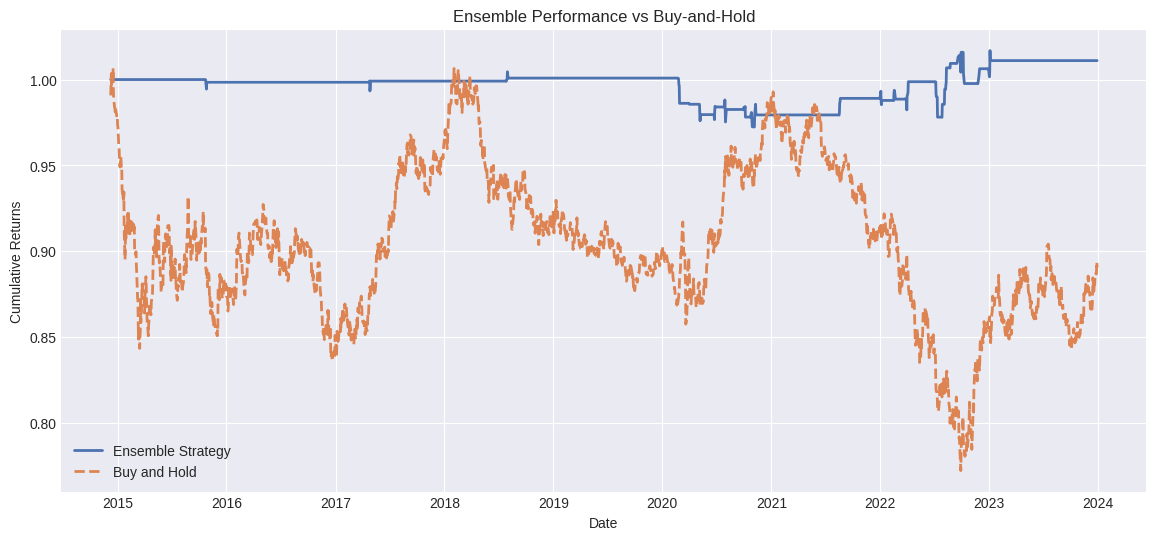


=== Model Interpretation ===
1. **Model Performance Comparison**:
- The ensemble model combines predictions from LSTM, CNN-LSTM, RandomForest, XGBoost, and OLS.
- If the ensemble's Sharpe, Sortino, and Calmar ratios are higher than individual models, it indicates improved risk-adjusted returns.
- Ensemble Sharpe Ratio: 0.08648254990886307
- Best Individual Model Sharpe Ratio: 0.33660472955874937

2. **Comparison with Buy-and-Hold**:
- The buy-and-hold strategy represents a passive benchmark.
- Ensemble Cumulative Return: 0.011053449730012987
- Buy-and-Hold Cumulative Return: -0.1095529308683677

3. **Risk Management Impact**:
- Anomaly-aware trade management adjusts positions based on reconstruction error.
- Ensemble Max Drawdown: -0.03203707348289586

4. **Tuned Thresholds for Each Model**:
- LSTM: entry_threshold = 3.0, exit_threshold = 1.0, hold_period = 11
- CNN-LSTM: entry_threshold = 2.1, exit_threshold = 0.9, hold_period = 4
- RandomForest: entry_threshold = 0.6, exit_threshold

In [ ]:
def evaluate_performance(df: pd.DataFrame) -> Dict[str, float]:
    if 'Strategy_Returns_RM' in df.columns:
        returns = df['Strategy_Returns_RM'].fillna(0)
        cumulative_returns = df['Cumulative_Returns_RM'].fillna(1)
    else:
        # For buy-and-hold or cases where Strategy_Returns_RM is missing, compute returns from cumulative returns
        logging.warning("Strategy_Returns_RM not found. Computing returns from Cumulative_Returns_RM.")
        cumulative_returns = df['Cumulative_Returns_RM'].fillna(1)
        returns = cumulative_returns.pct_change().fillna(0)

    sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() != 0 else 0
    sortino = sortino_ratio(returns)
    calmar = calmar_ratio(cumulative_returns)
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

    return {
        'Cumulative_Return': cumulative_returns.iloc[-1] - 1,
        'Sharpe_Ratio': sharpe_ratio,
        'Sortino_Ratio': sortino,
        'Calmar_Ratio': calmar,
        'Max_Drawdown': max_drawdown
    }

def plot_performance(df: pd.DataFrame, label: str, buy_and_hold: pd.Series):
    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['Cumulative_Returns_RM'], label=f'{label} Strategy', linewidth=2)
    # Align buy_and_hold with df['Date'] by trimming to the same length
    buy_and_hold_aligned = buy_and_hold.iloc[-len(df):].values
    plt.plot(df['Date'], buy_and_hold_aligned, label='Buy and Hold', linestyle='--', linewidth=2)
    plt.title(f'{label} Performance vs Buy-and-Hold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate Buy-and-Hold benchmark
buy_and_hold = (1 + data['Close'].pct_change().fillna(0)).cumprod()
buy_and_hold_df = pd.DataFrame({'Date': data['Date'], 'Cumulative_Returns_RM': buy_and_hold})
buy_and_hold_metrics = evaluate_performance(buy_and_hold_df)

# Evaluate all models
performance_metrics = {'Buy_and_Hold': buy_and_hold_metrics}
for model_name, rm_df in risk_managed_results.items():
    performance_metrics[model_name] = evaluate_performance(rm_df)

# Note: This section is redundant since ensemble_rm_df is already computed in Cell 13
# But keeping it for consistency with the original code
# Ensemble predictions by averaging
ensemble_predictions = np.nanmean([preds for model_name, preds in predictions.items()], axis=0)
ensemble_signal_df = generate_signals(data, ensemble_predictions, data['Volatility'], CONFIG['entry_threshold'], CONFIG['exit_threshold'], CONFIG['hold_period'])
ensemble_rm_df = apply_risk_management(ensemble_signal_df, CONFIG['max_position'], CONFIG['hold_period'], transaction_cost=0.0001)
performance_metrics['Ensemble'] = evaluate_performance(ensemble_rm_df)

# Display metrics
metrics_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
metrics_df.index.name = 'Model'
print(metrics_df)

# Plot ensemble performance
plot_performance(ensemble_rm_df, 'Ensemble', buy_and_hold)

# Interpretation
print("\n=== Model Interpretation ===")
print("1. **Model Performance Comparison**:")
print("- The ensemble model combines predictions from LSTM, CNN-LSTM, RandomForest, XGBoost, and OLS.")
print("- If the ensemble's Sharpe, Sortino, and Calmar ratios are higher than individual models, it indicates improved risk-adjusted returns.")
print(f"- Ensemble Sharpe Ratio: {performance_metrics['Ensemble']['Sharpe_Ratio']}")
print(f"- Best Individual Model Sharpe Ratio: {max([metrics['Sharpe_Ratio'] for model, metrics in performance_metrics.items() if model != 'Ensemble' and model != 'Buy_and_Hold'])}")

print("\n2. **Comparison with Buy-and-Hold**:")
print("- The buy-and-hold strategy represents a passive benchmark.")
print(f"- Ensemble Cumulative Return: {performance_metrics['Ensemble']['Cumulative_Return']}")
print(f"- Buy-and-Hold Cumulative Return: {performance_metrics['Buy_and_Hold']['Cumulative_Return']}")

print("\n3. **Risk Management Impact**:")
print("- Anomaly-aware trade management adjusts positions based on reconstruction error.")
print(f"- Ensemble Max Drawdown: {performance_metrics['Ensemble']['Max_Drawdown']}")

print("\n4. **Tuned Thresholds for Each Model**:")
for model_name in best_thresholds.keys():
    print(f"- {model_name}: entry_threshold = {best_thresholds[model_name]['entry_threshold']}, "
          f"exit_threshold = {best_thresholds[model_name]['exit_threshold']}, "
          f"hold_period = {best_thresholds[model_name]['hold_period']}")

# Comment: Updated interpretation to include hold_period in the tuned thresholds display.